# import


In [40]:
import sys
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set_style("whitegrid")
color = sns.cubehelix_palette(rot=-.2)
color_heatmap = sns.diverging_palette(10, 260, s=100, l=50, sep=1, as_cmap=True)
plt.rcParams['font.family'] = 'NanumGothic'

root_path = f".."
data_path = f"{root_path}/data"
data_olist_path = f"{data_path}/olist"

In [41]:
def get_var_name(variable):
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]


class EDA:
    def __init__(
        self: pd.DataFrame,
        df,
        idx=None,
        x=None,
        y=None,
        fig_col_len=2,
    ) -> pd.DataFrame:

        self.idx = idx
        if idx != None:
            temp = df.set_index(idx)
            self.df = temp
        else:
            self.df = df

        if x == None:
            self.x = df.columns.to_list()
        else:
            self.x = x

        self.y = y
        self.fig_col_len = fig_col_len

    def print_title(body, br=2, bp="┌▣ ", hr=" ---- ---- ---- ----"):

        """
        body : 내용
        bp : bullet point, 글머리 기호
        hr : Horizontal Rule, 수평선
        """

        class ff:
            PURPLE = "\033[95m"
            CYAN = "\033[96m"
            DARKCYAN = "\033[36m"
            BLUE = "\033[94m"
            GREEN = "\033[92m"
            YELLOW = "\033[93m"
            RED = "\033[91m"
            BOLD = "\033[1m"
            UNDERLINE = "\033[4m"
            END = "\033[0m"

        print("\n" * br + ff.BOLD + bp + ff.UNDERLINE + body + ff.END + hr)

    def Check_df(df):

        EDA.print_title("""df.shape""")
        print(df.shape)

        EDA.print_title("""df.info()""")
        print(df.info())

        EDA.print_title("""df.head()""")
        display(df.head())

        EDA.print_title("""df.columns.to_list()""")
        print(df.columns.to_list())

    def Check(self) -> pd.DataFrame:

        df = self.df
        EDA.Check_df(df)

    def Summary_df(df):

        EDA.print_title("""df.describe().T""")
        display(df.describe().T)

        try:
            EDA.print_title("""df.describe(include=['O'])""")
            display(df.describe(include=["O"]))
        except:
            pass

        # 결측치
        df_temp = df.isna()
        EDA.print_title("""df.isna().sum()""")
        display(df_temp.sum().to_frame())

        EDA.print_title("""sns.heatmap(data=df.isna())""")
        sns.heatmap(data=df.isna(), cmap="Greys")
        plt.title("""sns.heatmap(data=df.isna())""", fontsize=20)
        plt.show()

        EDA.print_title("df.isna().mean()")
        display(df_temp.mean().to_frame())

    def Summary(self):

        df = self.df
        EDA.Summary_df(df)

    def mv(self) -> None:

        df = self.df

        fig_col_len = self.fig_col_len
        import math

        fig_row_len = math.ceil(len(self.x) / fig_col_len)

        sns.pairplot(data=df, height=len(self.x) * 4)

        df_corr = df.corr()
        EDA.print_title("""df.corr()""")
        display(df_corr)
        EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
        plt.figure(figsize=(20, 7))
        sns.heatmap(
            data=df_corr, annot=True, fmt=".2f", annot_kws={"size": 14}, cmap="Blues"
        )
        plt.show()

# 주문 승인과 고객 배송 날짜 사이의 상관관계

→ 배송 날짜가 늦어질수록 review score가 낮음

**(리뷰 데이터 예시 보여주기) 분석 (리뷰 데이터 14000개 돌아다니면서 관련 내용)**

- 배송 예정일과 실제 배송 시간 간의 차이
- 배송 프로세스에 들어가는 비용이 많음 (프로세스를 줄일 수 있으면 줄이는 게 경제적, 시간적으로 효율적)
- 배송 프로세스별 시간 얼마나 걸리는지
- 지역별로 필요한 배송 서비스가 다름 (대도시와 시골 지역의 인프라 차이) → 반영되었는지 모름

## Data Load

In [42]:
df_raw = pd.read_csv(f"{data_olist_path}/complete_orders.csv", index_col=0)

### Check

In [43]:
# EDA.Check_df(df_raw)

### Summary


In [44]:
# EDA.Summary_df(df_raw)

## 파생열 만들기

["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
"order_delivered_customer_date", "order_estimated_delivery_date", "review_score"]

- order_purchase_timestamp : 구매 타임스탬프를 표시합니다.

- order_approved_at : 결제 승인 타임스탬프를 표시합니다.

- order_delivered_carrier_date : 주문 전기 타임스탬프를 표시합니다. 물류 파트너에게 처리되었을 때.

- **order_delivered_customer_date : 고객에게 실제 주문 배송 날짜를 표시합니다.**

- order_estimated_delivery_date : 구매 시점에 고객에게 통보된 예상 납기를 보여줍니다.

- review_score : 1~5

In [45]:
df_cor = df_raw.copy()

col_list = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_score",
]
dt_list = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
deri_list = ["delivered_purchase", "estimated_purchase", "delivered_estimated", "delivered_carrier", "carrier_purchase"]
dict_title = {
    deri_list[0]: "배송기간_실제",
    deri_list[1]: "배송기간_예상",
    deri_list[2]: "배송기간_실제예상차이",
    deri_list[3]: "배송원에게 전달된 후 소비자가 배송받은 시간",
    deri_list[4]: "구매 후 배송원에게 전달된 시간",
}


for i in dt_list:
    df_cor[i] = pd.to_datetime(df_cor[i])

df_cor["delivered_purchase"] = (
    df_cor["order_delivered_customer_date"] - df_cor["order_purchase_timestamp"]
)

df_cor["estimated_purchase"] = (
    df_cor["order_estimated_delivery_date"] - df_cor["order_purchase_timestamp"]
)

df_cor["delivered_estimated"] = (
    df_cor["order_delivered_customer_date"] - df_cor["order_estimated_delivery_date"]
)

df_cor["delivered_carrier"] = (
    df_cor["order_delivered_customer_date"] - df_cor["order_delivered_carrier_date"]
)

df_cor["carrier_purchase"] = (
    df_cor["order_delivered_carrier_date"] - df_cor["order_purchase_timestamp"]
)

# EDA.Check_df(df_cor)
# EDA.Summary_df(df_cor)

## 이상치 제거 : delivered_purchase

### sns.boxplot

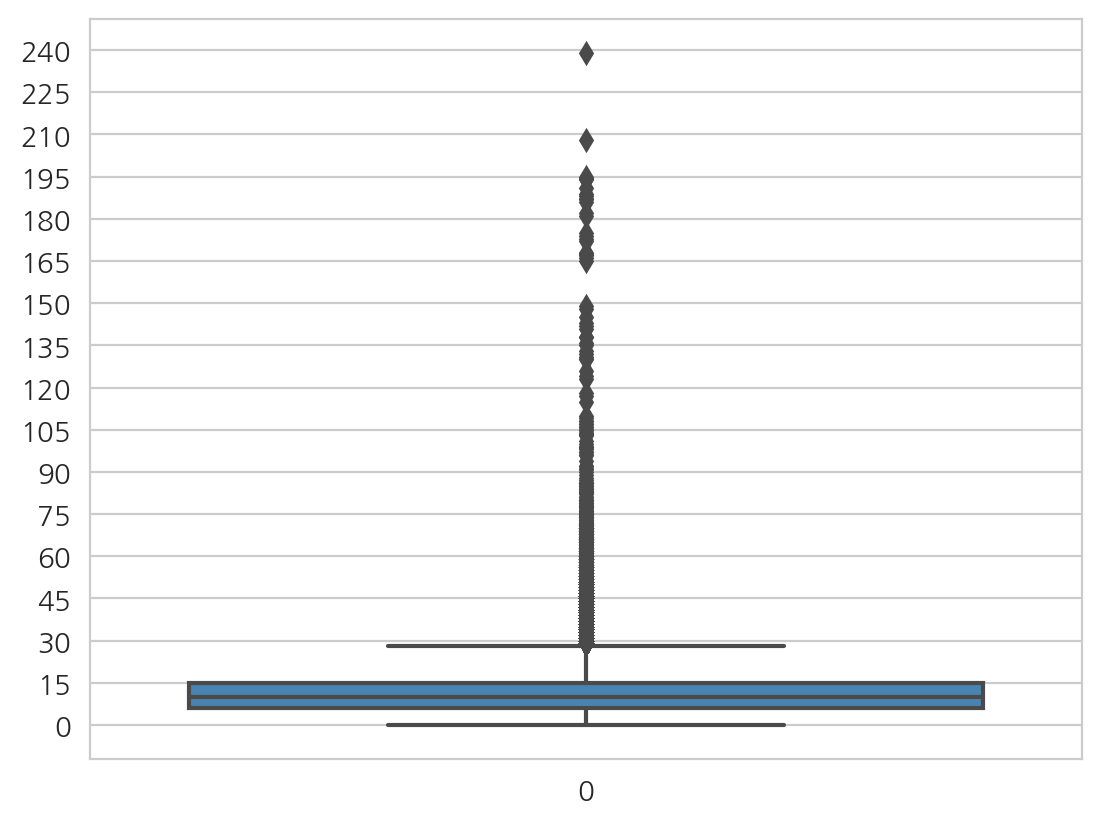

In [46]:
y = list(range(0, 260, 15))
plt.yticks(y)
sns.boxplot(
    data=df_cor["delivered_purchase"]
    .dt.days.astype(str)
    .str.split(" days ")
    .str[0]
    .astype(int),
    palette = "Blues_d"
)
plt.show()

### sns.displot

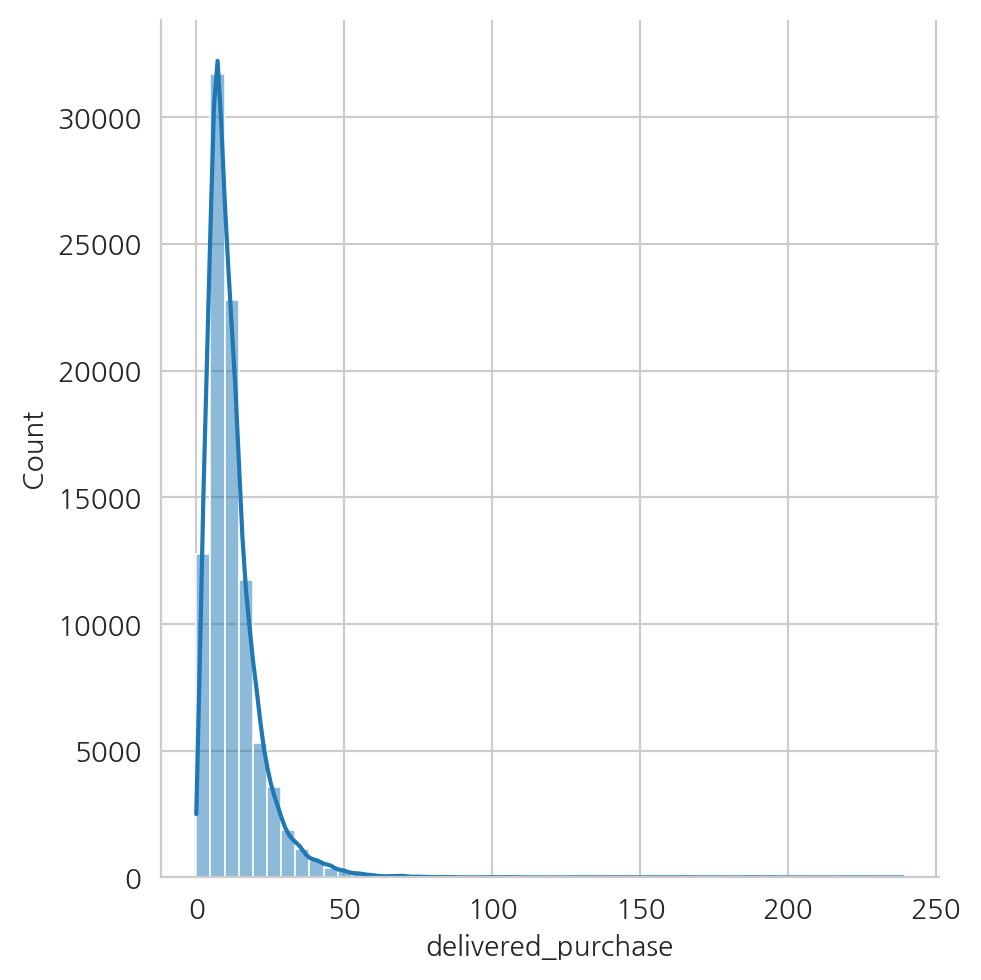

In [47]:
sns.displot(
    data=df_cor["delivered_purchase"].dt.days.astype(str).str.split(" days ").str[0].astype(int), 
    palette = "Blues_d", 
    bins=50, 
    # binwidth=2,
    kde=True,
    )

### 이상치 제거 : delivered_purchase 30 days

In [48]:
df_cor_outlierDrop = df_cor.copy()
df_cor_outlierDrop = df_cor_outlierDrop[
    df_cor_outlierDrop["delivered_purchase"] < "30 days 00:00:00"
]

print("df_cor_outlierDrop 행의 수 :", df_cor_outlierDrop.shape[0])
print("제거 된 행의 수 :", df_cor.shape[0] - df_cor_outlierDrop.shape[0])

display(df_cor_outlierDrop.describe().T)

df_cor_outlierDrop 행의 수 : 88331
제거 된 행의 수 : 4326


count                          mean  \
zip_code_prefix_customer 88331.000                     34495.072   
geolocation_lat_customer 88331.000                       -21.374   
geolocation_lng_customer 88331.000                       -46.259   
zip_code_prefix_seller   88331.000                     24732.776   
geolocation_lat_seller   88331.000                       -22.805   
geolocation_lng_seller   88331.000                       -47.228   
order_item_id            88331.000                         1.126   
price                    88331.000                       123.848   
freight_value            88331.000                        19.790   
review_score             88331.000                         4.248   
payment_installments     88331.000                         2.894   
delivered_purchase           88331    11 days 03:33:32.608936839   
estimated_purchase           88331    23 days 10:24:43.001766084   
delivered_estimated          88331  -13 days +17:08:49.607170756   
delivered_carrier            88331     8 days 02:31:37.487744959   
carrier_purchase             88331     3 days 01:01:55.121191880   

                                                std                  min  \
zip_code_prefix_customer                  29836.033             1004.000   
geolocation_lat_customer                      5.373              -33.692   
geolocation_lng_customer                      3.953              -72.664   
zip_code_prefix_seller                    27818.516             1001.000   
geolocation_lat_seller                        2.740              -32.096   
geolocation_lng_seller                        2.359              -63.896   
order_item_id                                 0.511                1.000   
price                                       186.923                0.850   
freight_value                                15.286                0.000   
review_score                                  1.194                1.000   
payment_installments                          2.692                0.000   
delivered_purchase        6 days 04:23:00.482135426      0 days 12:48:07   
estimated_purchase        8 days 14:58:17.103657469      2 days 00:11:32   
delivered_estimated       7 days 23:52:45.653950951  -147 days +23:36:47   
delivered_carrier         5 days 14:00:40.158700362      0 days 00:00:00   
carrier_purchase          2 days 20:03:25.313664611      0 days 00:11:15   

                                                25%                 50%  \
zip_code_prefix_customer                   9961.000           23510.000   
geolocation_lat_customer                    -23.594             -22.938   
geolocation_lng_customer                    -48.101             -46.639   
zip_code_prefix_seller                     6429.000           13568.000   
geolocation_lat_seller                      -23.617             -23.425   
geolocation_lng_seller                      -48.810             -46.750   
order_item_id                                 1.000               1.000   
price                                        40.000              78.000   
freight_value                                13.070              16.180   
review_score                                  4.000               5.000   
payment_installments                          1.000               2.000   
delivered_purchase           6 days 12:52:17.500000     9 days 23:04:22   
estimated_purchase                 18 days 03:23:21    23 days 01:39:51   
delivered_estimated       -17 days +14:49:19.500000  -13 days +19:52:45   
delivered_carrier            4 days 00:19:39.500000     6 days 23:41:09   
carrier_purchase             1 days 02:52:33.500000     2 days 04:06:59   

                                              75%                max  
zip_code_prefix_customer                57038.500          99980.000  
geolocation_lat_customer                  -20.299             42.184  
geolocation_lng_customer                  -43.888             -4.948  
zip_code_prefix_sel

### 이상치 제거 후 sns.boxplot

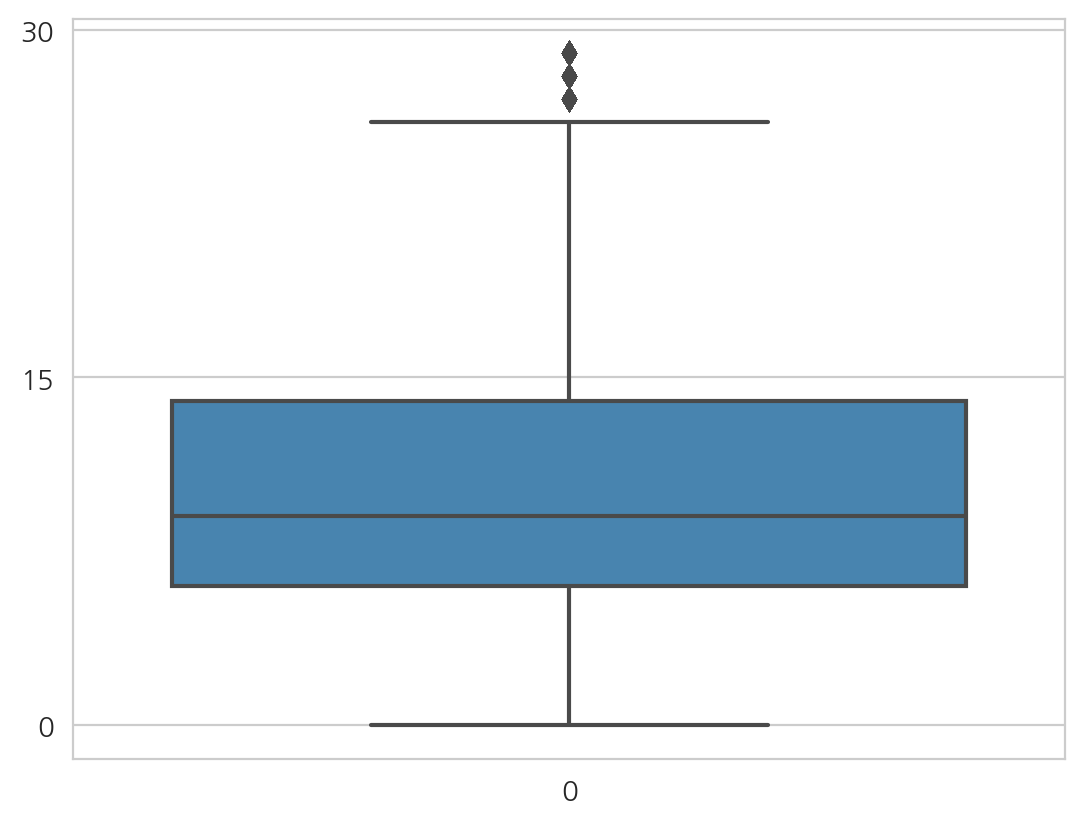

In [49]:
y = list(range(0, 260, 15))
plt.yticks(y)
sns.boxplot(
    data=df_cor_outlierDrop["delivered_purchase"]
    .dt.days.astype(str)
    .str.split(" days ")
    .str[0]
    .astype(int),
    palette = "Blues_d"
)
plt.show()

### 이상치 제거 후 sns.displot

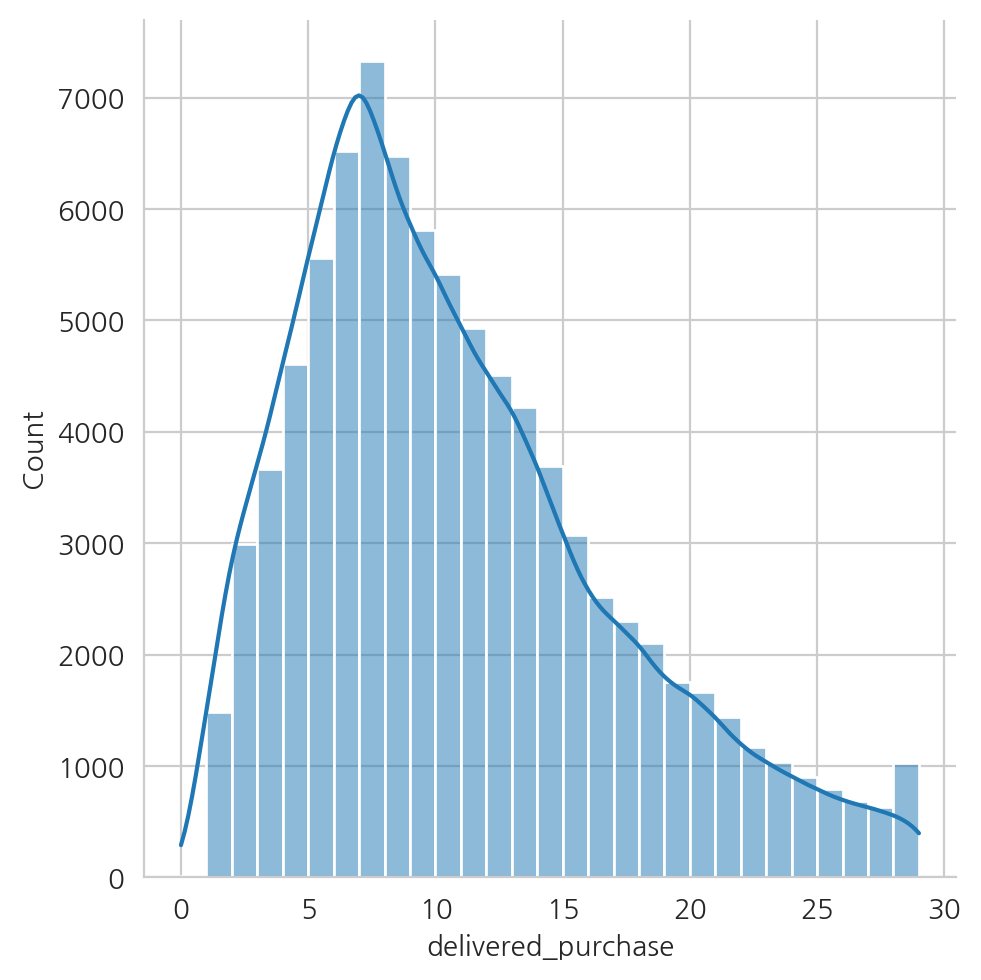

In [50]:
sns.displot(
    data=df_cor_outlierDrop["delivered_purchase"].dt.days.astype(str).str.split(" days ").str[0].astype(int), 
    palette = "Blues_d", 
    # bins=50, 
    binwidth=1,
    kde=True,
    )

## 상관 관계 파악

### df.corr()

In [51]:
df_temp = df_cor.copy()

for i in deri_list:
    df_temp[i] = df_temp[i].dt.days.astype(str).str.split(" days ").str[0].astype(int)
df_temp = df_temp.corr()

EDA.print_title("""df.corr()""")
display(df_temp)



┌▣ df.corr() ---- ---- ---- ----


zip_code_prefix_customer  geolocation_lat_customer  \
zip_code_prefix_customer                     1.000                     0.122   
geolocation_lat_customer                     0.122                     1.000   
geolocation_lng_customer                    -0.306                     0.452   
zip_code_prefix_seller                       0.077                    -0.035   
geolocation_lat_seller                      -0.010                     0.087   
geolocation_lng_seller                      -0.018                     0.088   
order_item_id                               -0.001                    -0.016   
price                                        0.042                     0.055   
freight_value                                0.227                     0.273   
review_score                                -0.023                    -0.044   
payment_installments                         0.057                     0.064   
delivered_purchase                           0.272                     0.257   
estimated_purchase                           0.381                     0.294   
delivered_estimated                         -0.074                    -0.013   
delivered_carrier                            0.293                     0.277   
carrier_purchase                             0.010                     0.011   

                          geolocation_lng_customer  zip_code_prefix_seller  \
zip_code_prefix_customer                    -0.306                   0.077   
geolocation_lat_customer                     0.452                  -0.035   
geolocation_lng_customer                     1.000                  -0.035   
zip_code_prefix_seller                      -0.035                   1.000   
geolocation_lat_seller                       0.076                  -0.135   
geolocation_lng_seller                       0.083                  -0.427   
order_item_id                               -0.015                  -0.013   
price                                        0.015                   0.086   
freight_value                                0.092                   0.160   
review_score                                -0.050                   0.023   
payment_installments                         0.038                   0.044   
delivered_purchase                           0.111                   0.049   
estimated_purchase                           0.064                   0.190   
delivered_estimated                          0.049                  -0.118   
delivered_carrier                            0.118                   0.049   
carrier_purchase                             0.010                   0.013   

                          geolocation_lat_seller  geolocation_lng_seller  \
zip_code_prefix_customer                  -0.010                  -0.018   
geolocation_lat_customer                   0.087                   0.088   
geolocation_lng_customer                   0.076                   0.083   
zip_code_prefix_seller                    -0.135                  -0.427   
geolocation_lat_seller                     1.000                   0.429   
geolocation_lng_seller                     0.429                   1.000   
order_item_id                             -0.002                  -0.010   
price                                      0.019                   0.047   
freight_value                              0.039                  -0.008   
review_score                              -0.011                   0.015   
payment_installments                       0.011                  -0.006   
delivered_purchase                         0.052                  -0.044   
estimated_purchase                         0.036                  -0.075   
delivered_estimated                        0.017                   0.023   
delivered_carrier                          0.056                  -0.040   
carrier_purchase                           0.002                  -0.020   

                          order_item_id  pric

### sns.heatmap



┌▣ sns.heatmap(data=df.corr(), annot=True, fmt=".2f") ---- ---- ---- ----


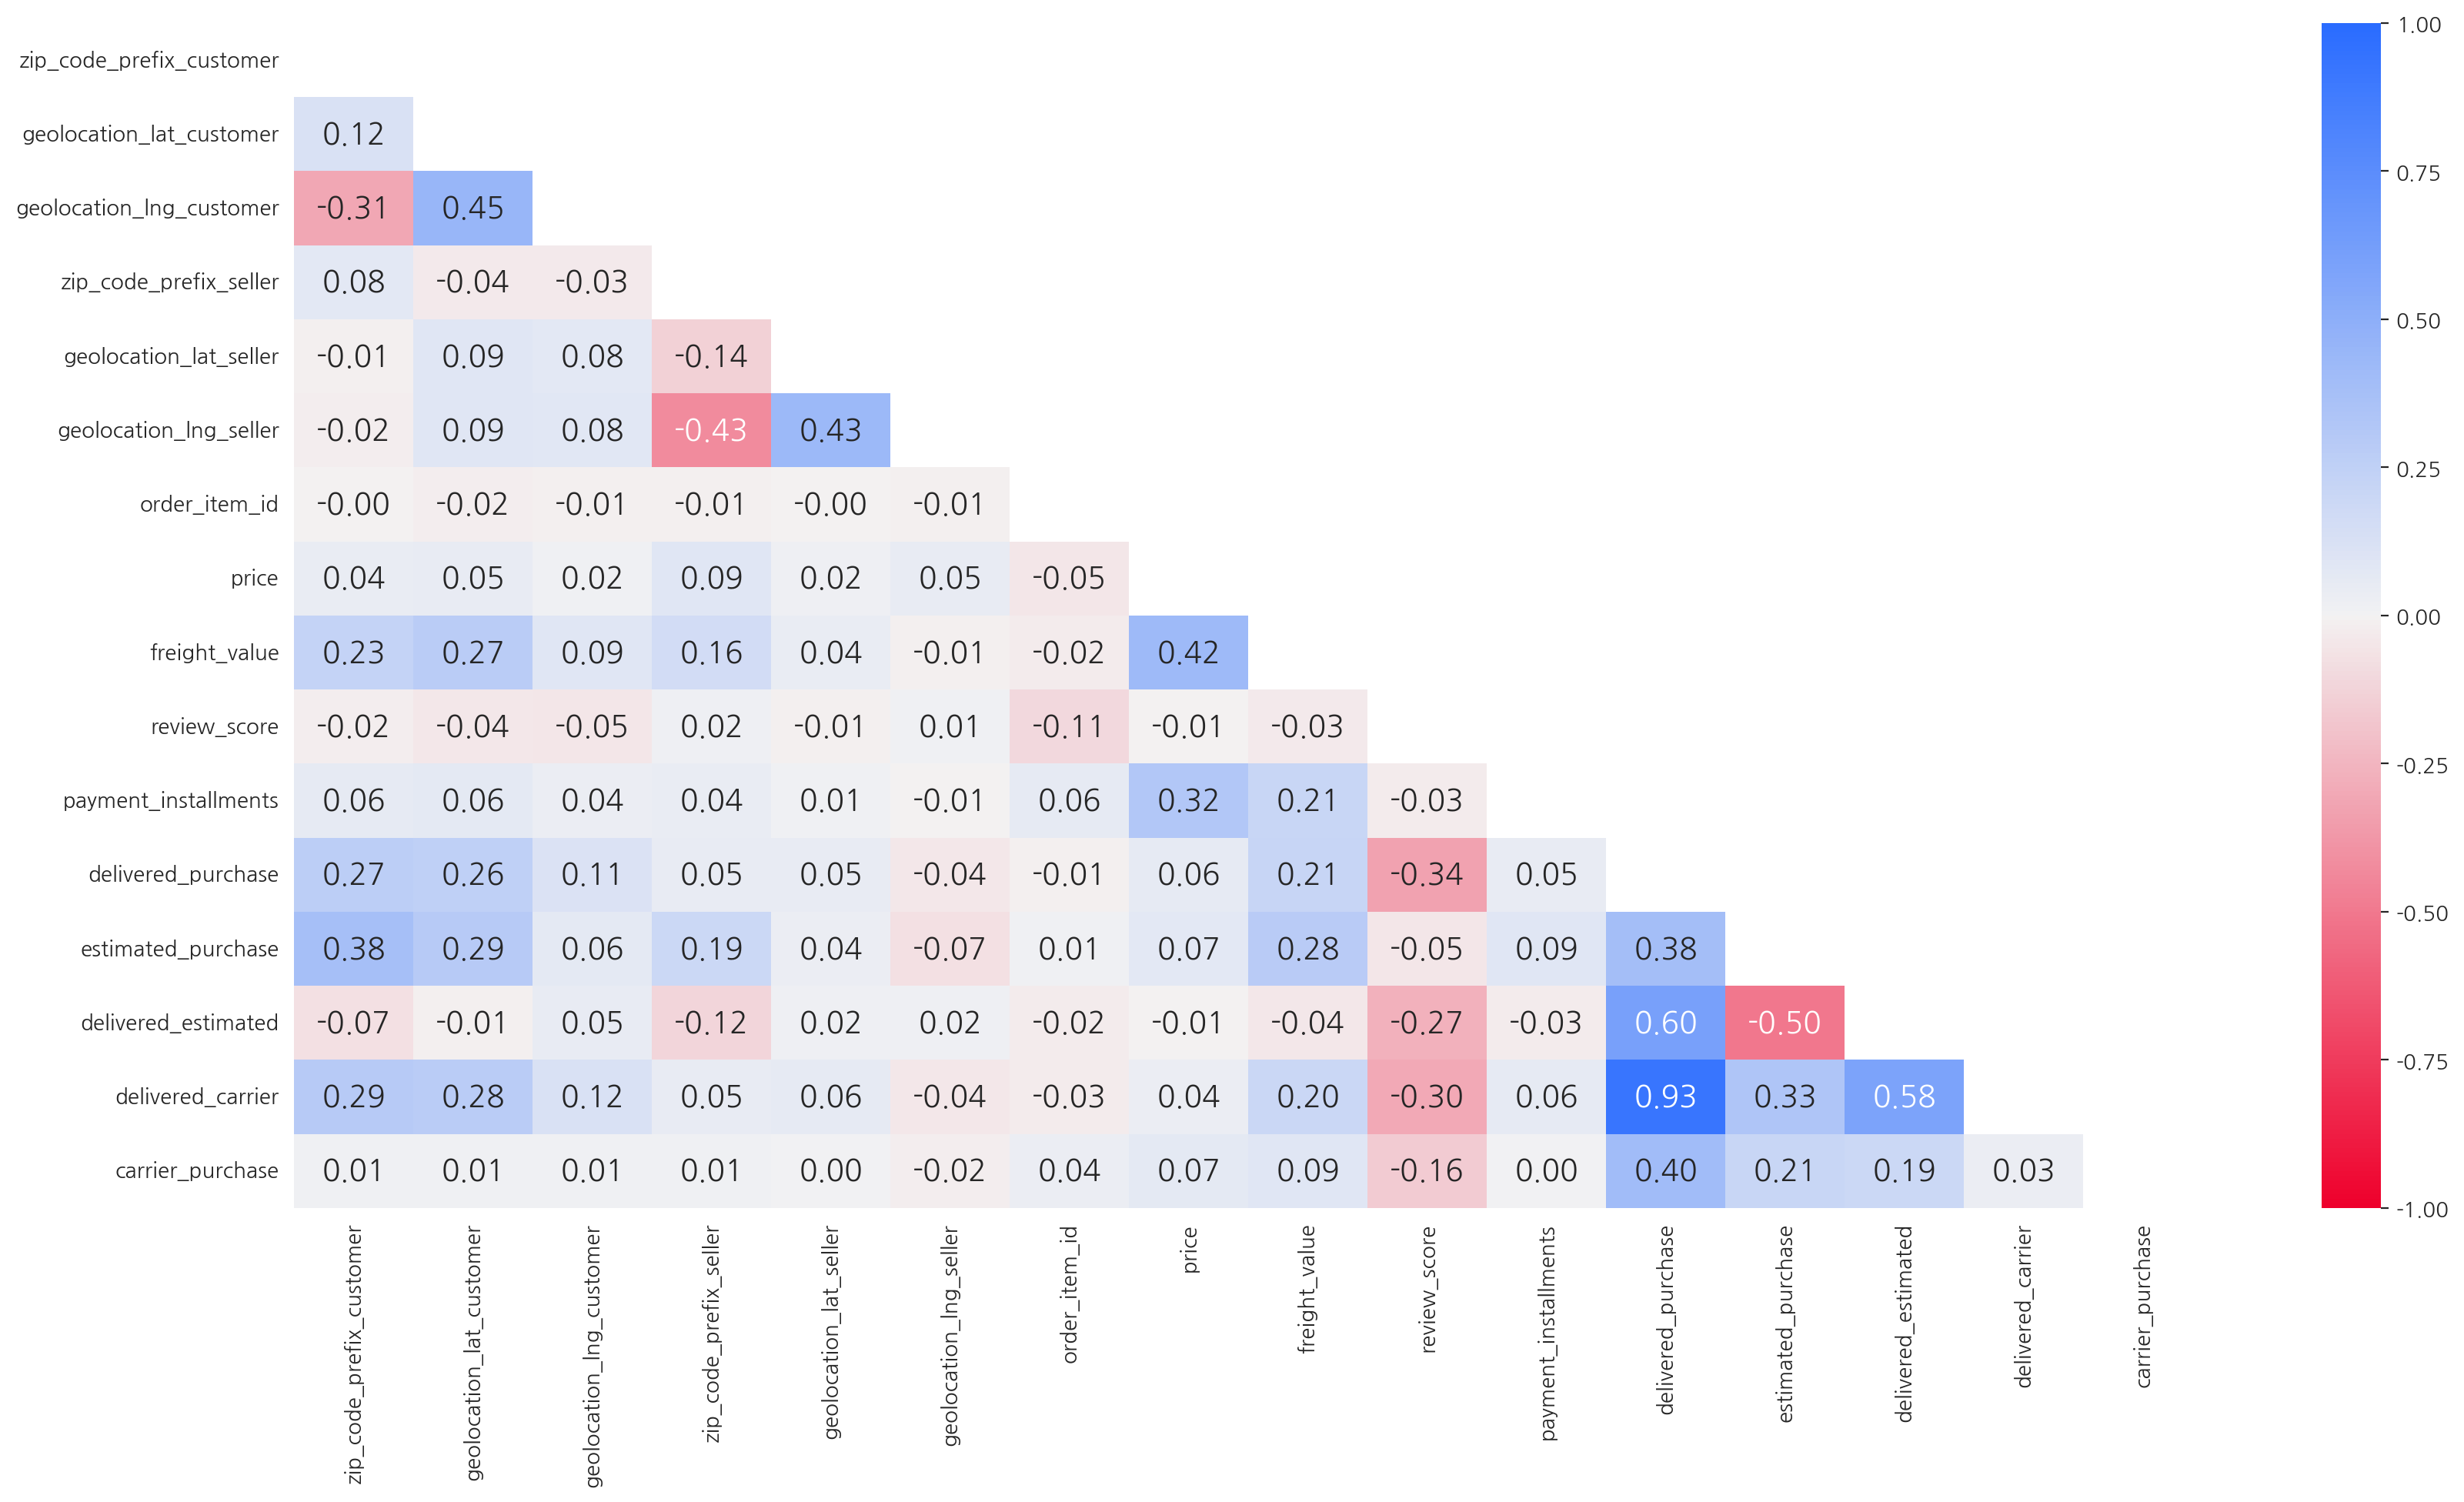

In [52]:
mask=np.zeros_like(df_temp,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
plt.figure(figsize=(20, 10))
plt.title(f"")
sns.heatmap(data=df_temp, annot=True, fmt=".2f", annot_kws={"size": 14}, cmap=color_heatmap, mask=mask, vmin=-1, vmax=1)
plt.show()

### sns.heatmap2 - ["review_score"]



┌▣ sns.heatmap(data=df.corr(), annot=True, fmt=".2f") ---- ---- ---- ----


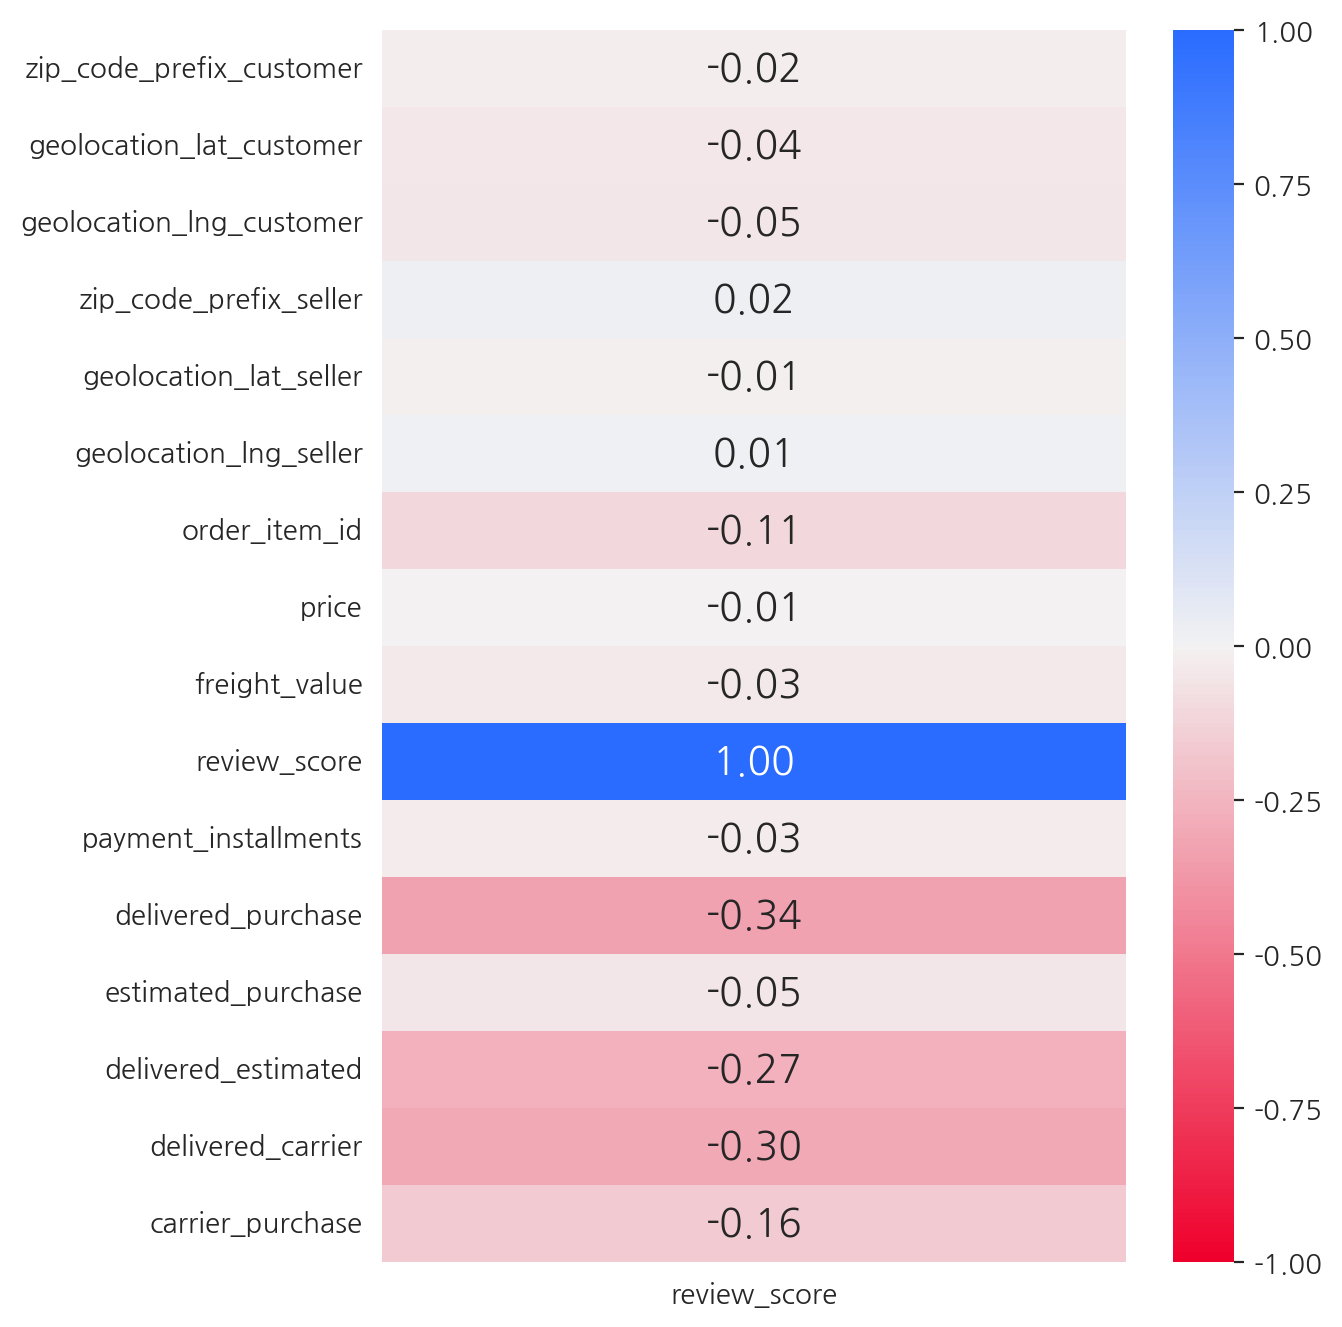

In [53]:
EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
plt.figure(figsize=(6, 8))
plt.title(f"")
sns.heatmap(data=df_temp["review_score"].to_frame(), annot=True, fmt=".2f", annot_kws={"size": 14}, cmap=color_heatmap, vmin=-1, vmax=1)
# sns.heatmap(data=df_temp["review_score"])
plt.show()

### sns.heatmap3 - ["review_score"][deri_list]



┌▣ sns.heatmap(data=df.corr(), annot=True, fmt=".2f") ---- ---- ---- ----


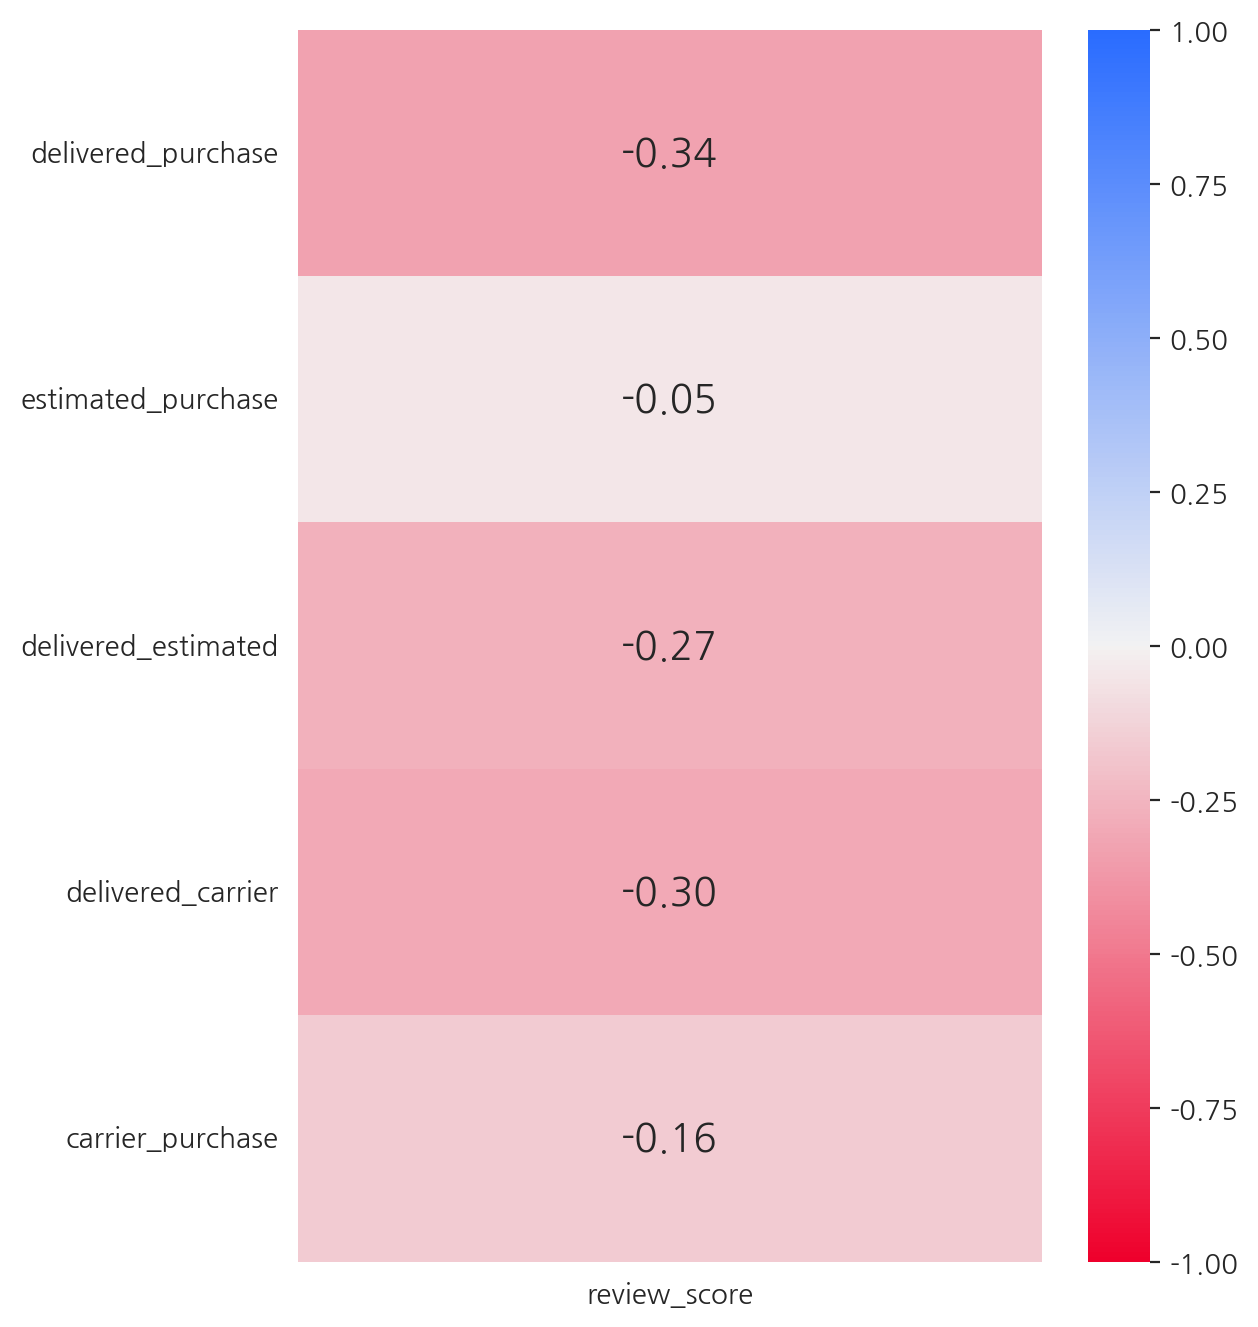

In [54]:
EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
plt.figure(figsize=(6, 8))
plt.title(f"")
sns.heatmap(data=df_temp["review_score"][deri_list].to_frame(), annot=True, fmt=".2f", annot_kws={"size": 14}, cmap=color_heatmap, vmin=-1, vmax=1)
# sns.heatmap(data=df_temp["review_score"])
plt.show()

### sns.regplot

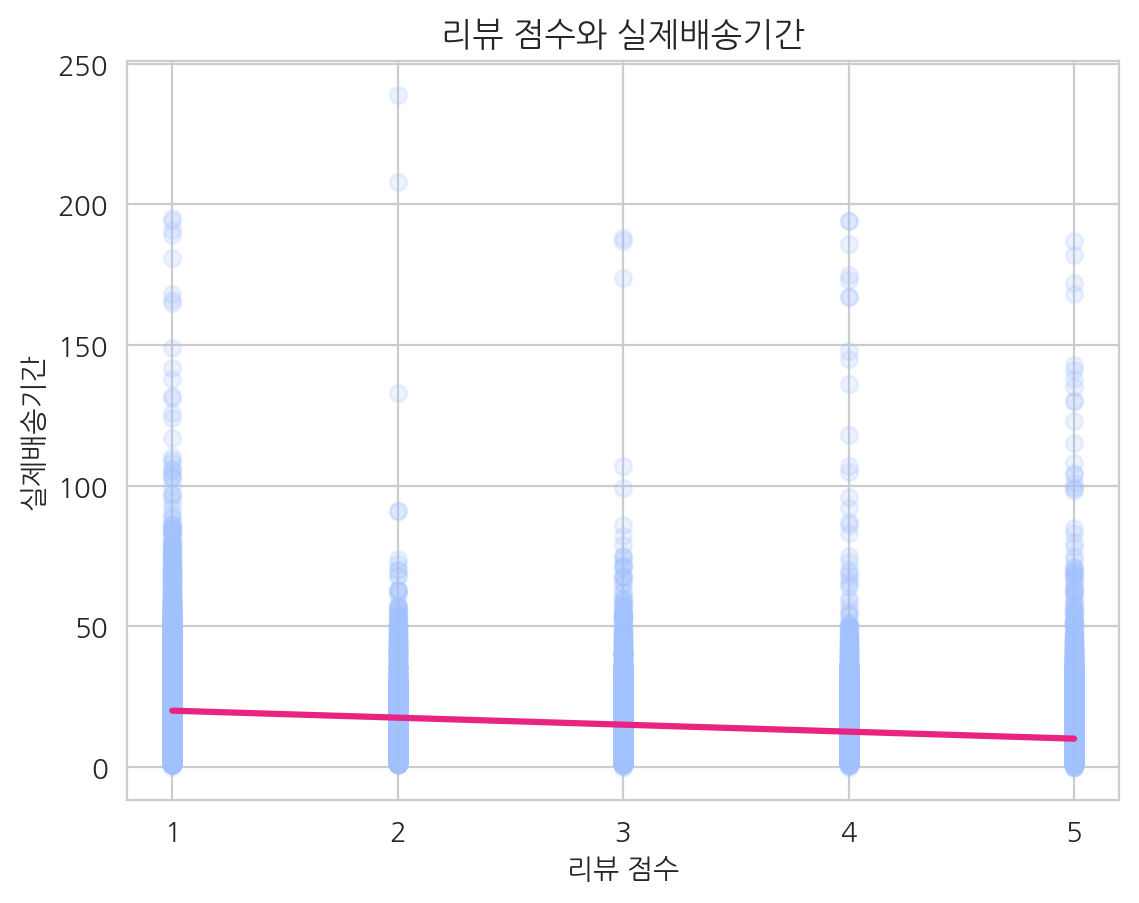

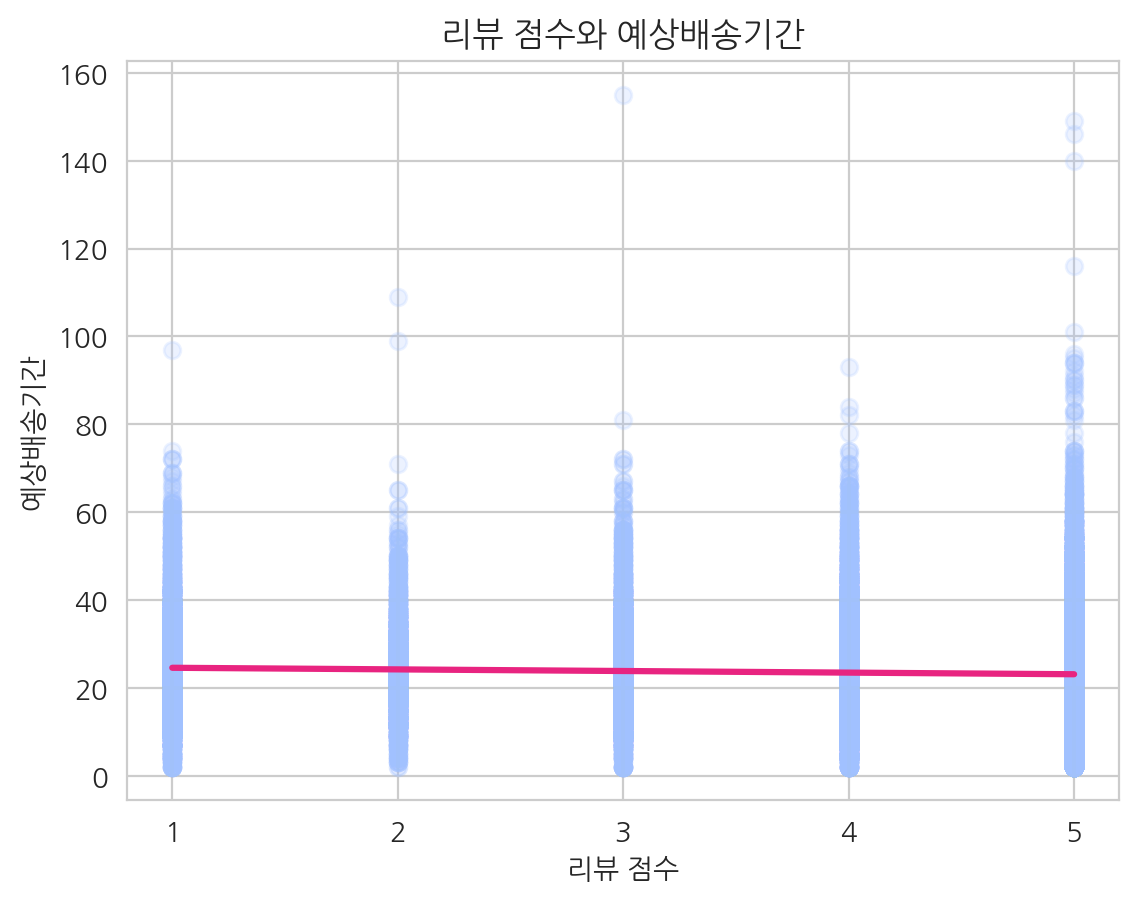

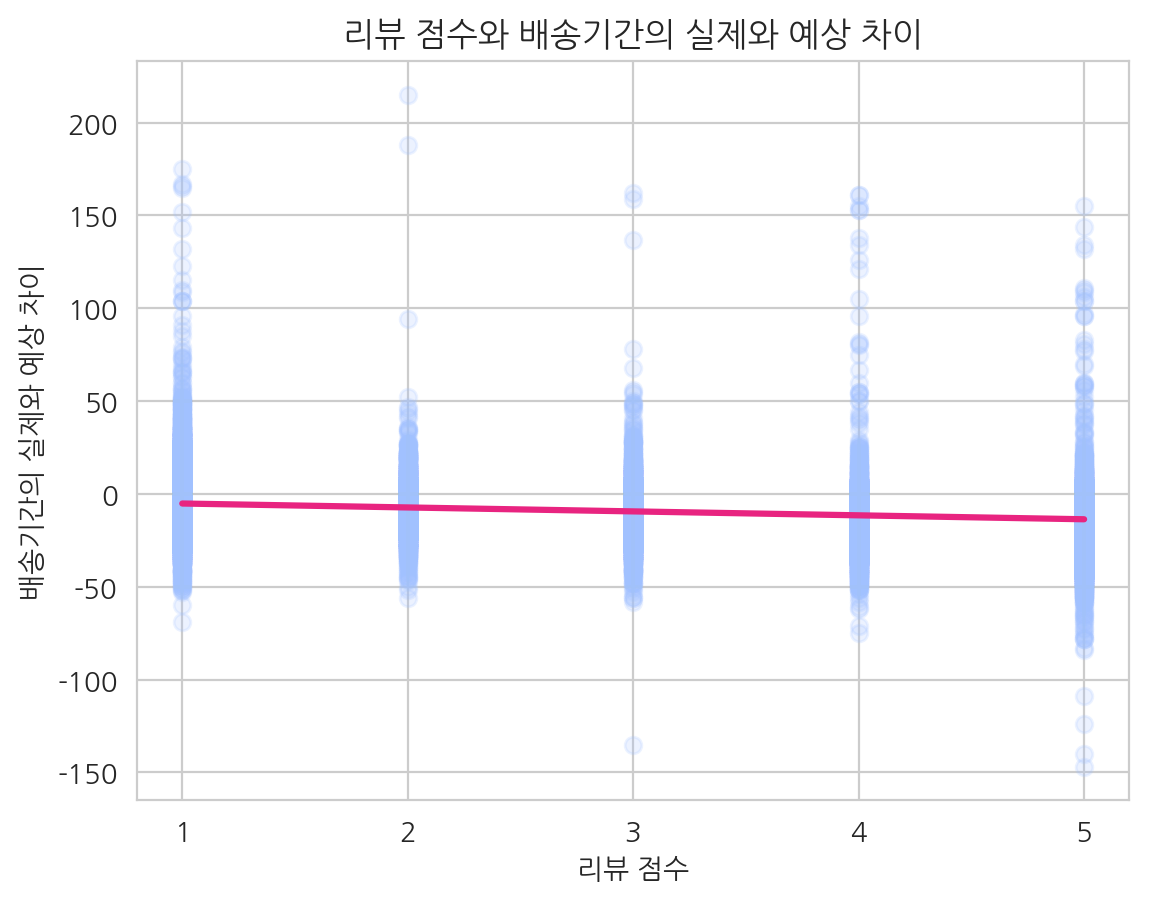

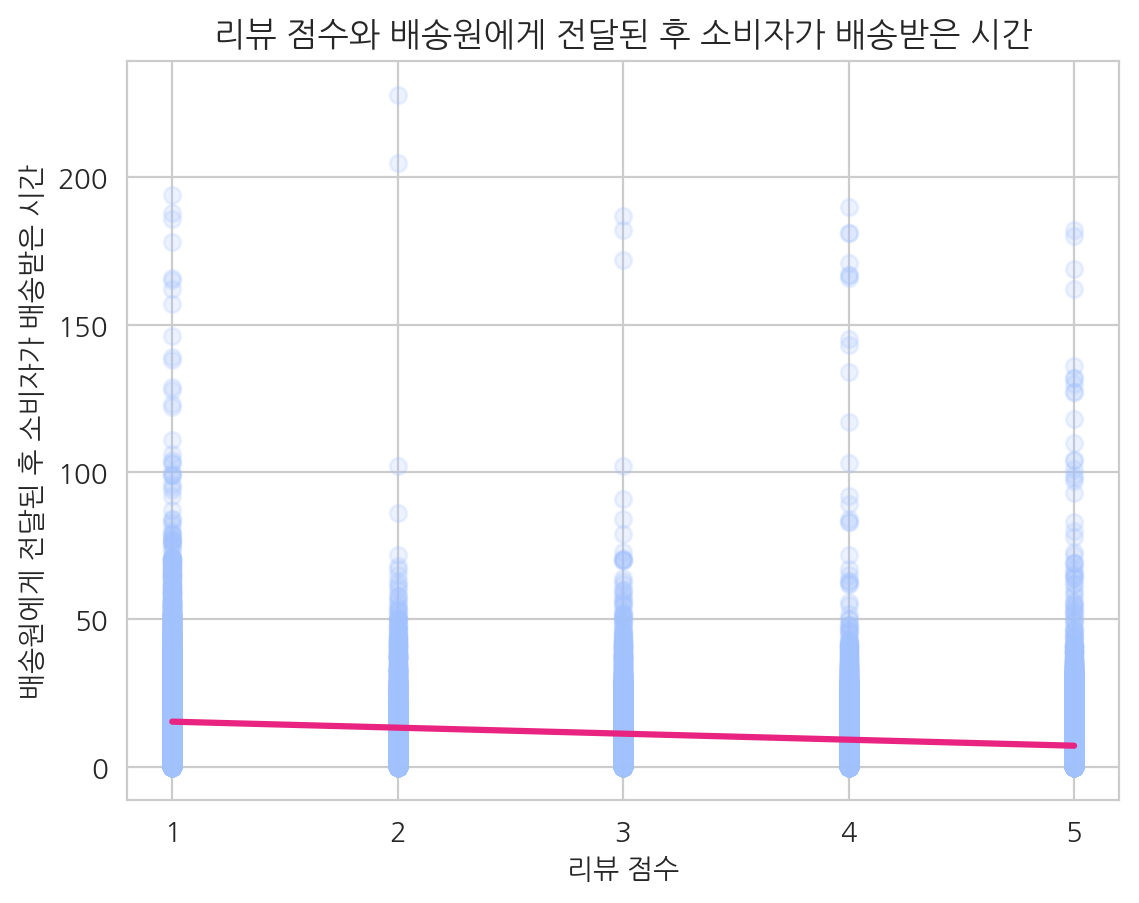

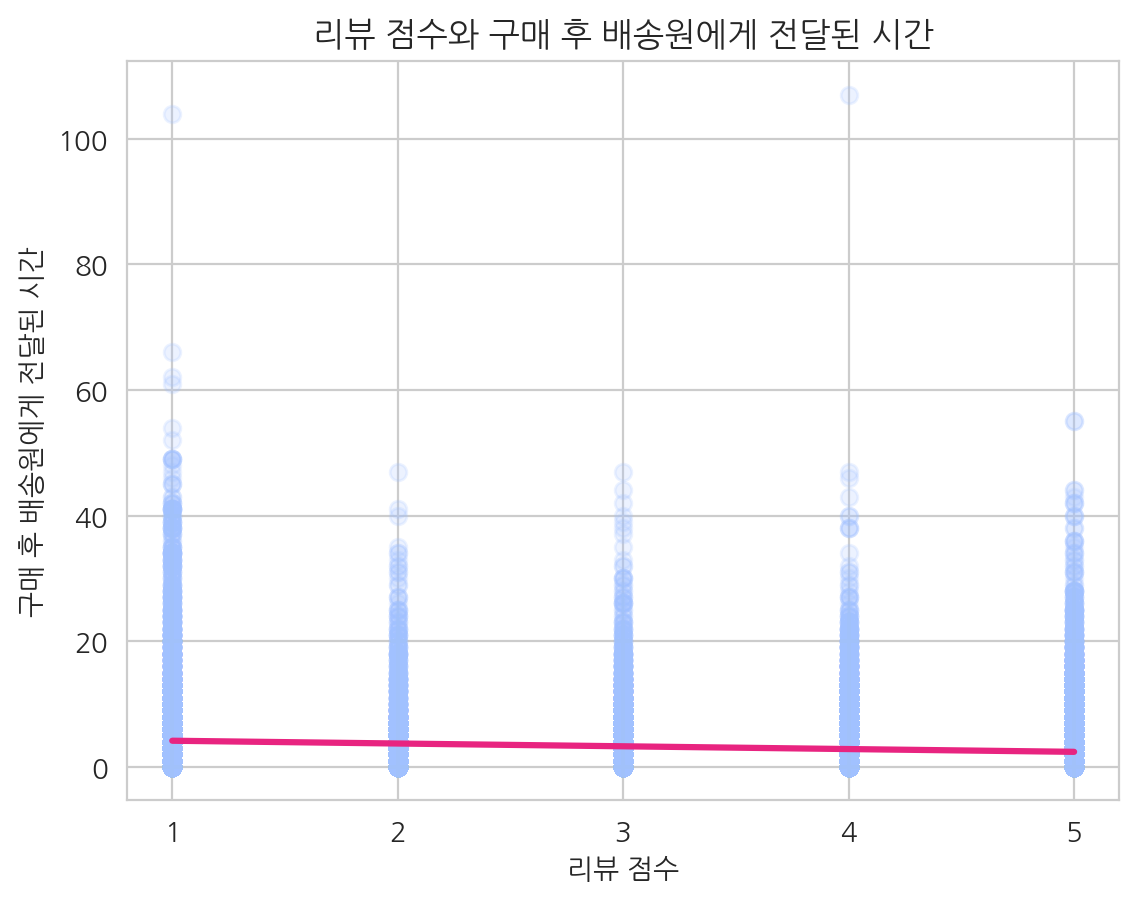

In [55]:
df_temp = df_cor.copy().reset_index()

df_temp[deri_list + ["review_score"]]

for i in deri_list:
    df_temp[i] = df_temp[i].dt.days
    sns.regplot(data=df_temp, x="review_score", y=i, scatter_kws={"color": "#a1c1ff", "alpha": 0.2}, line_kws= {"color":"#e82480", "alpha": 1})
    plt.title(f"리뷰 점수와 {dict_title[i]}")
    plt.xlabel("리뷰 점수")
    plt.xticks(ticks=[1, 2, 3, 4, 5])
    plt.ylabel(f"{dict_title[i]}")
    plt.show()

### sns.barplot

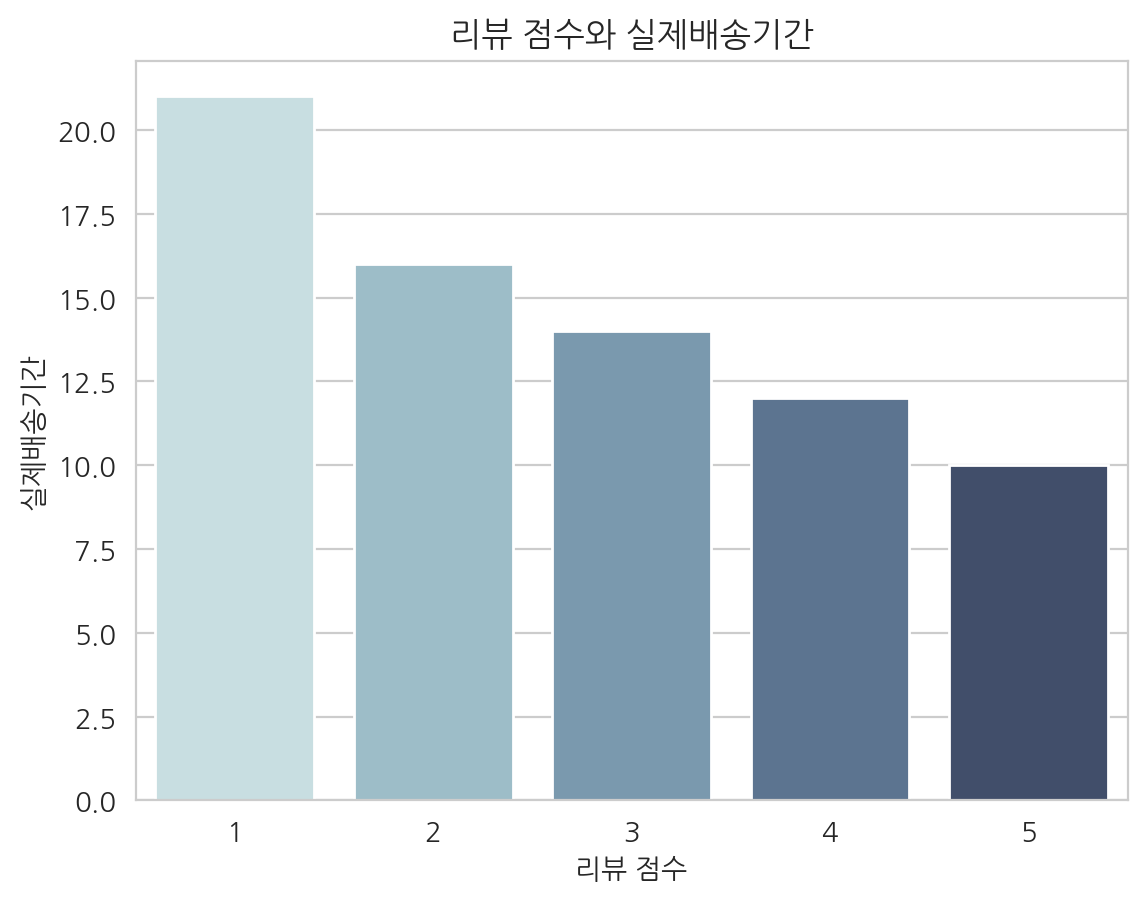

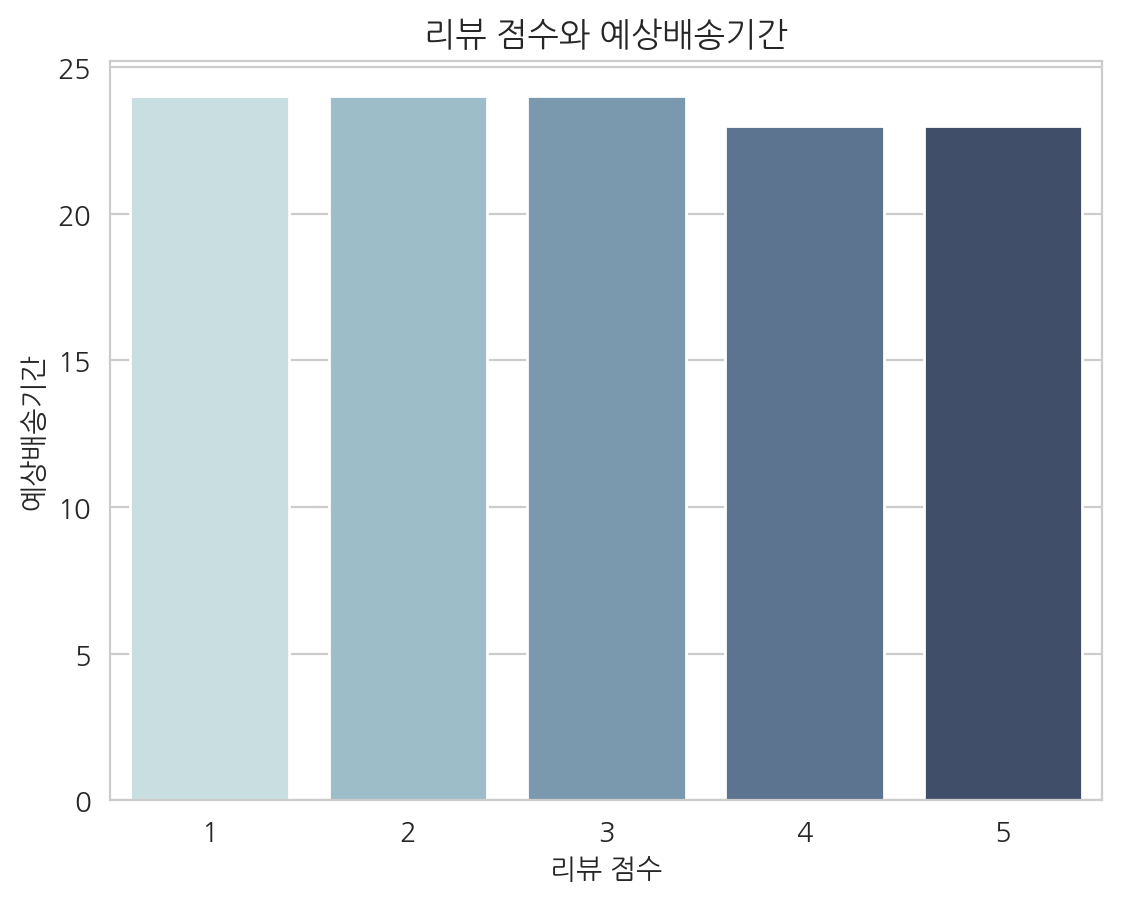

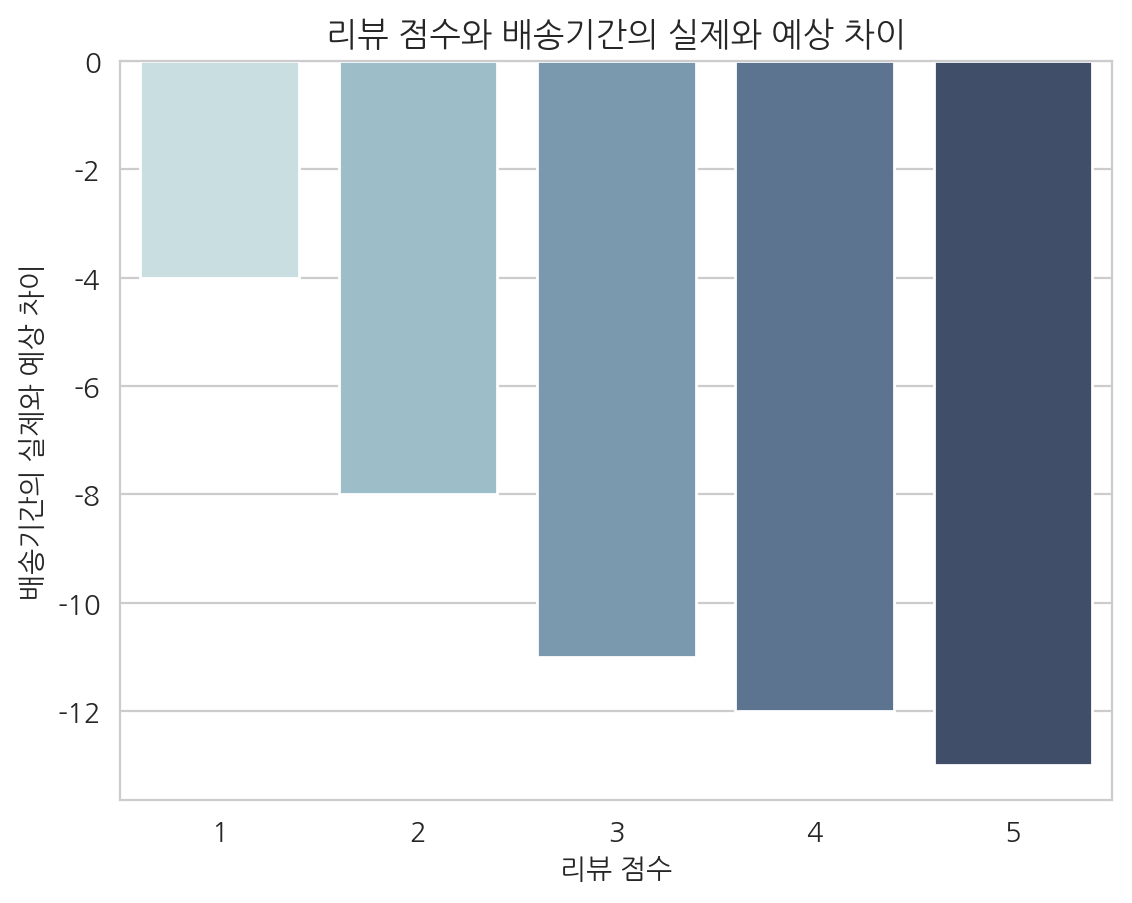

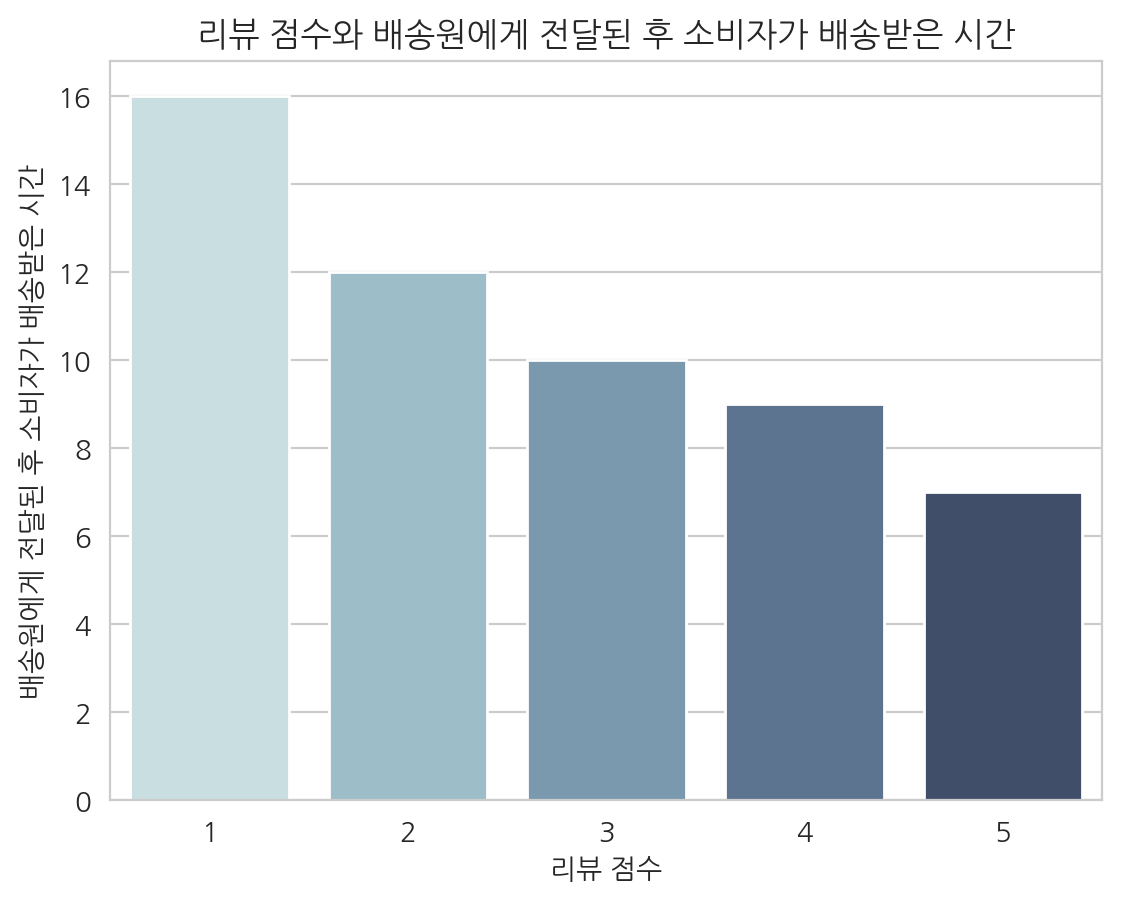

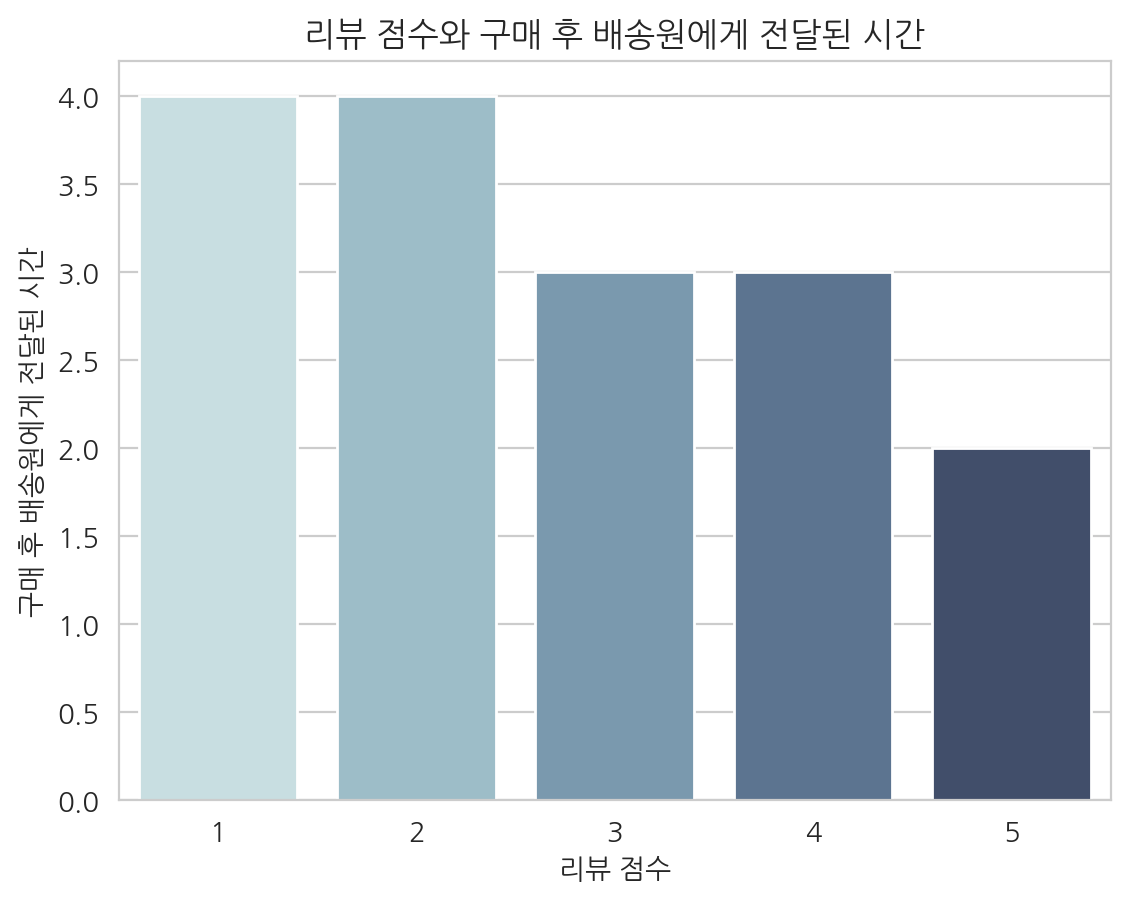

In [56]:
df_temp = df_cor.copy().reset_index()[deri_list + ["review_score"]].groupby("review_score")[deri_list].mean().reset_index()

for i in deri_list:
    df_temp[i] = df_temp[i].dt.days

for i in deri_list:
    sns.barplot(data=df_temp, x="review_score", y=i, palette=color)
    plt.title(f"리뷰 점수와 {dict_title[i]}")
    plt.xlabel("리뷰 점수")
    plt.ylabel(f"{dict_title[i]}")
    plt.show()

## 상관 관계 파악_이상치 제거 후

### df.corr()

In [57]:
df_temp = df_cor_outlierDrop.copy()

for i in deri_list:
    df_temp[i] = df_temp[i].dt.days.astype(str).str.split(" days ").str[0].astype(int)
df_temp = df_temp.corr()

EDA.print_title("""df.corr()""")
display(df_temp)



┌▣ df.corr() ---- ---- ---- ----


zip_code_prefix_customer  geolocation_lat_customer  \
zip_code_prefix_customer                     1.000                     0.109   
geolocation_lat_customer                     0.109                     1.000   
geolocation_lng_customer                    -0.313                     0.464   
zip_code_prefix_seller                       0.084                    -0.038   
geolocation_lat_seller                      -0.013                     0.095   
geolocation_lng_seller                      -0.019                     0.095   
order_item_id                               -0.001                    -0.016   
price                                        0.040                     0.048   
freight_value                                0.226                     0.261   
review_score                                 0.001                    -0.013   
payment_installments                         0.056                     0.058   
delivered_purchase                           0.348                     0.276   
estimated_purchase                           0.381                     0.280   
delivered_estimated                         -0.141                    -0.089   
delivered_carrier                            0.387                     0.309   
carrier_purchase                            -0.002                    -0.006   

                          geolocation_lng_customer  zip_code_prefix_seller  \
zip_code_prefix_customer                    -0.313                   0.084   
geolocation_lat_customer                     0.464                  -0.038   
geolocation_lng_customer                     1.000                  -0.040   
zip_code_prefix_seller                      -0.040                   1.000   
geolocation_lat_seller                       0.080                  -0.139   
geolocation_lng_seller                       0.095                  -0.426   
order_item_id                               -0.014                  -0.013   
price                                        0.013                   0.087   
freight_value                                0.090                   0.168   
review_score                                -0.021                   0.026   
payment_installments                         0.034                   0.044   
delivered_purchase                           0.092                   0.078   
estimated_purchase                           0.066                   0.201   
delivered_estimated                          0.000                  -0.156   
delivered_carrier                            0.103                   0.086   
carrier_purchase                            -0.001                   0.002   

                          geolocation_lat_seller  geolocation_lng_seller  \
zip_code_prefix_customer                  -0.013                  -0.019   
geolocation_lat_customer                   0.095                   0.095   
geolocation_lng_customer                   0.080                   0.095   
zip_code_prefix_seller                    -0.139                  -0.426   
geolocation_lat_seller                     1.000                   0.434   
geolocation_lng_seller                     0.434                   1.000   
order_item_id                             -0.001                  -0.010   
price                                      0.022                   0.049   
freight_value                              0.044                  -0.008   
review_score                              -0.004                   0.009   
payment_installments                       0.011                  -0.006   
delivered_purchase                         0.066                  -0.053   
estimated_purchase                         0.038                  -0.077   
delivered_estimated                        0.009                   0.042   
delivered_carrier                          0.070                  -0.052   
carrier_purchase                           0.004                  -0.014   

                          order_item_id  pric

### sns.heatmap



┌▣ sns.heatmap(data=df.corr(), annot=True, fmt=".2f") ---- ---- ---- ----


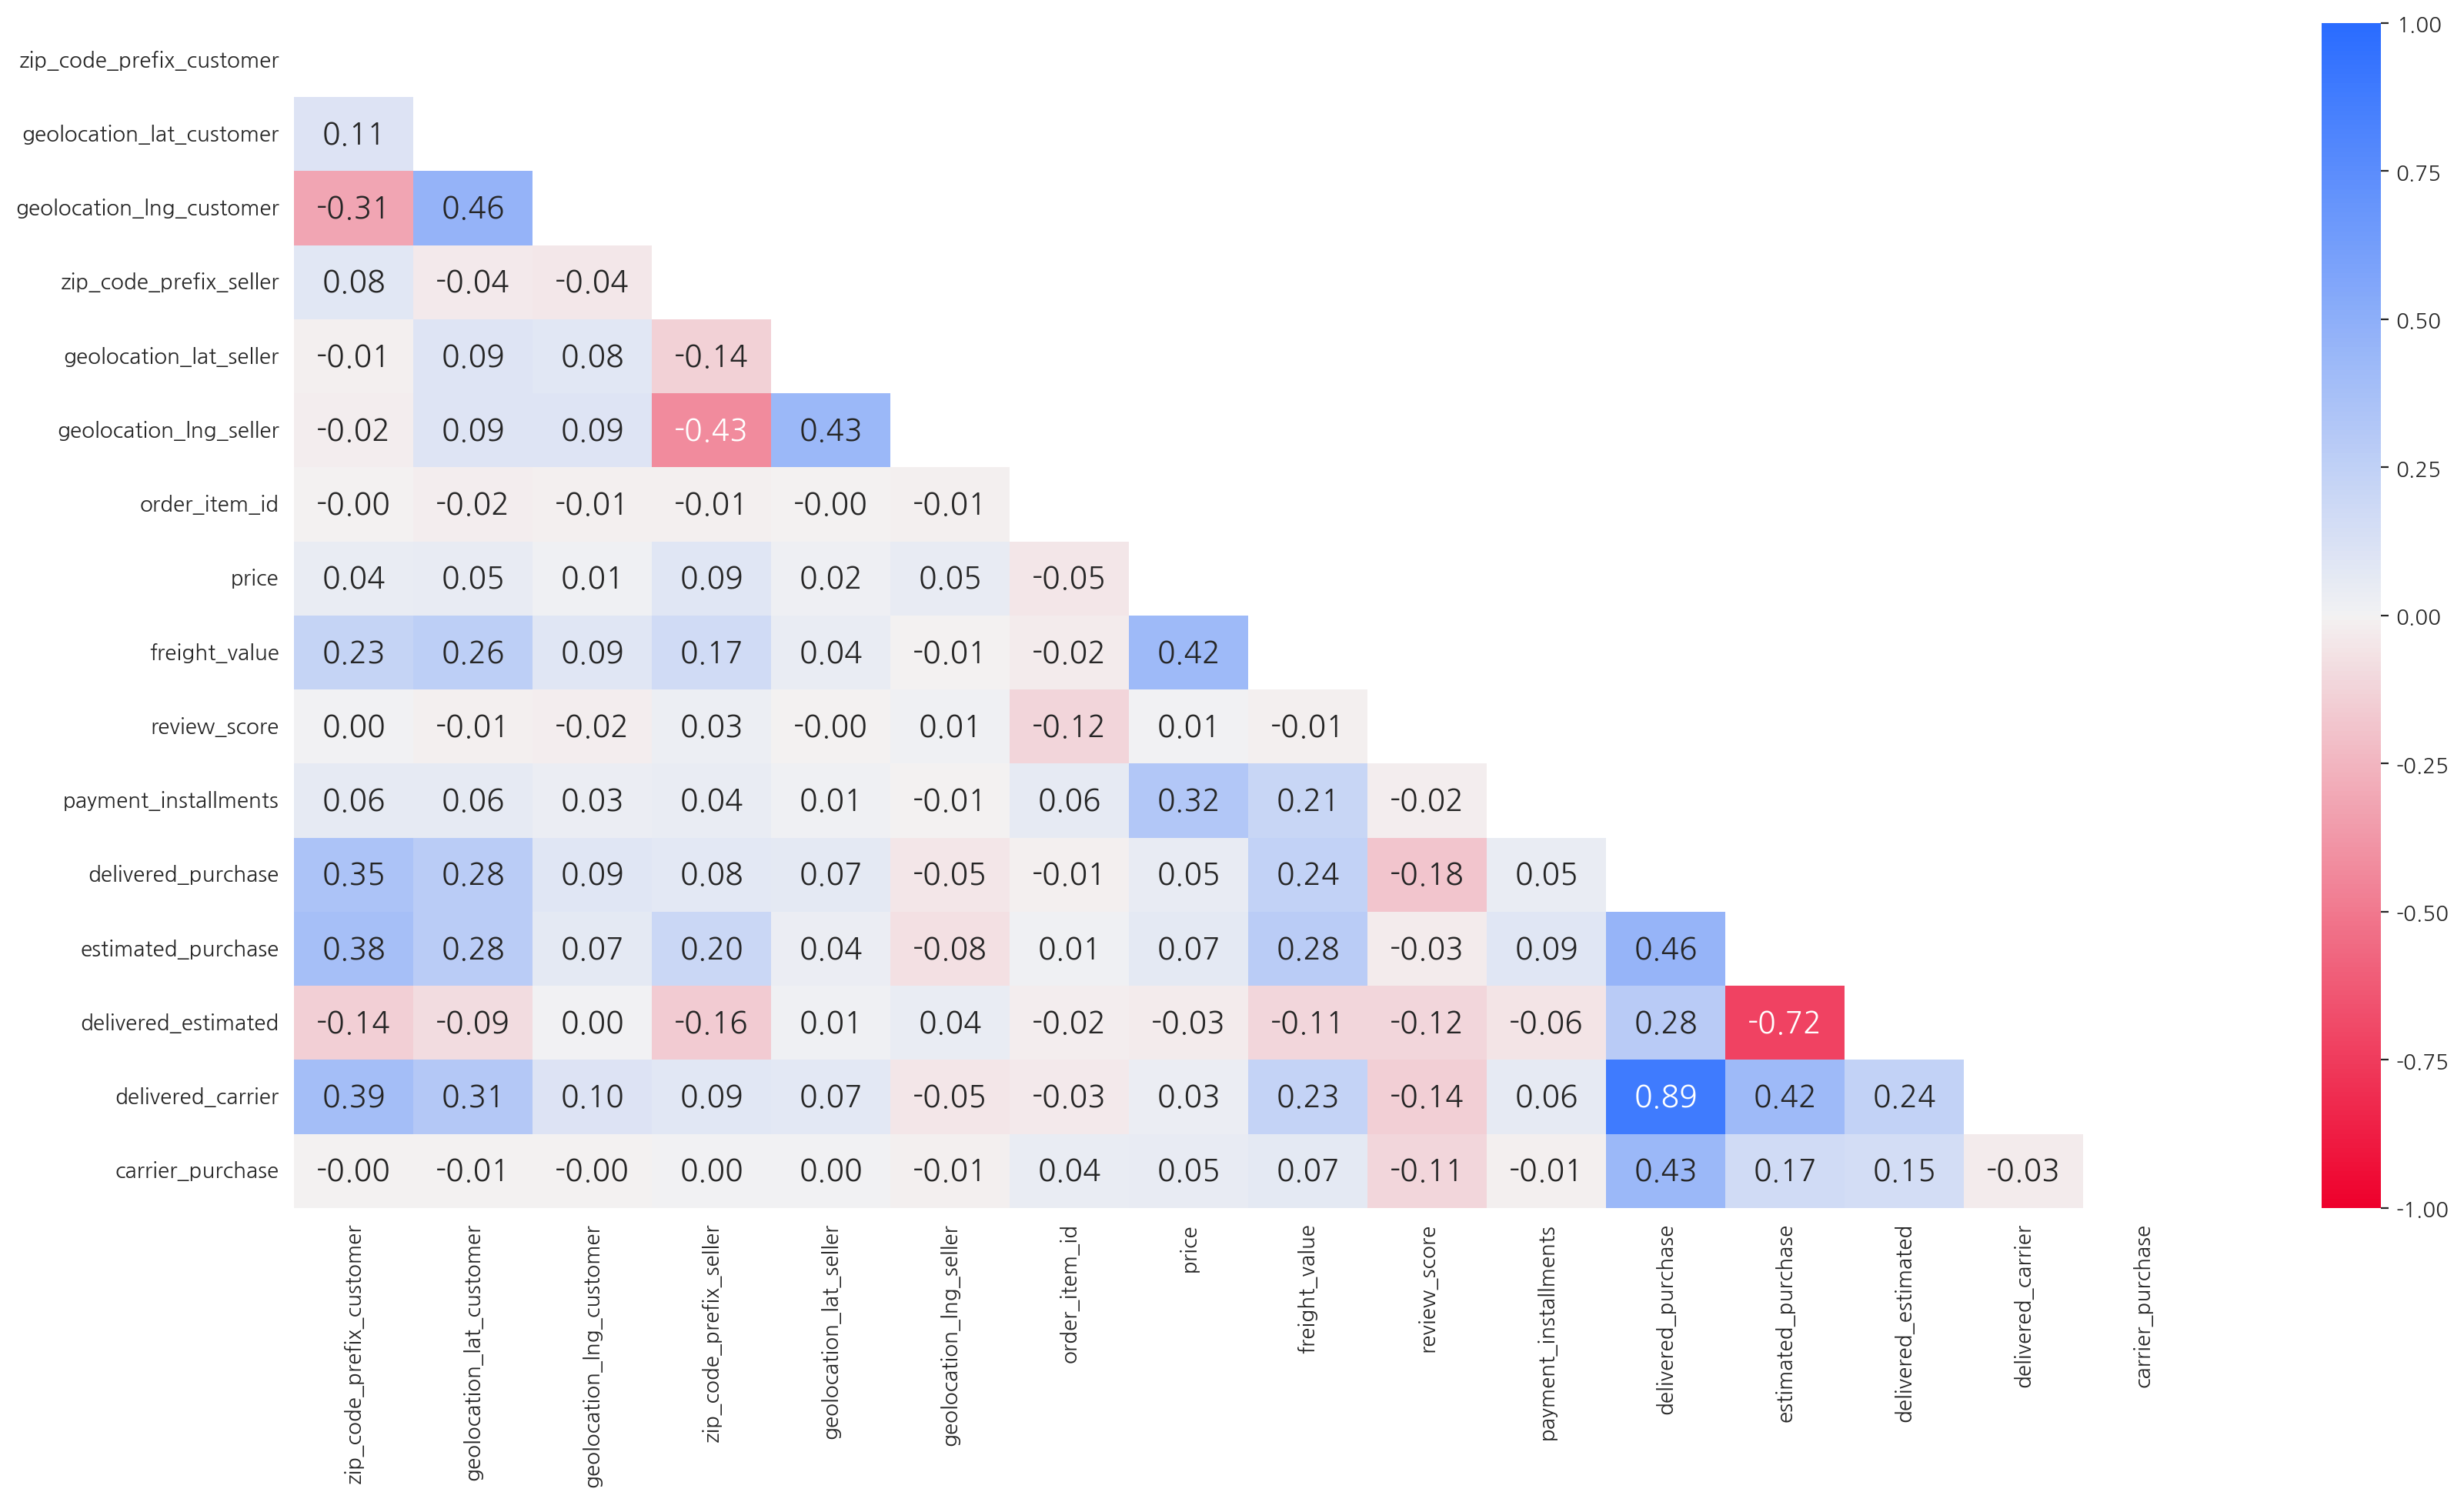

In [58]:
mask=np.zeros_like(df_temp,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
plt.figure(figsize=(20, 10))
plt.title(f"")
sns.heatmap(data=df_temp, annot=True, fmt=".2f", annot_kws={"size": 14}, cmap=color_heatmap, mask=mask, vmin=-1, vmax=1)
plt.show()

### sns.heatmap2 - ["review_score"]



┌▣ sns.heatmap(data=df.corr(), annot=True, fmt=".2f") ---- ---- ---- ----


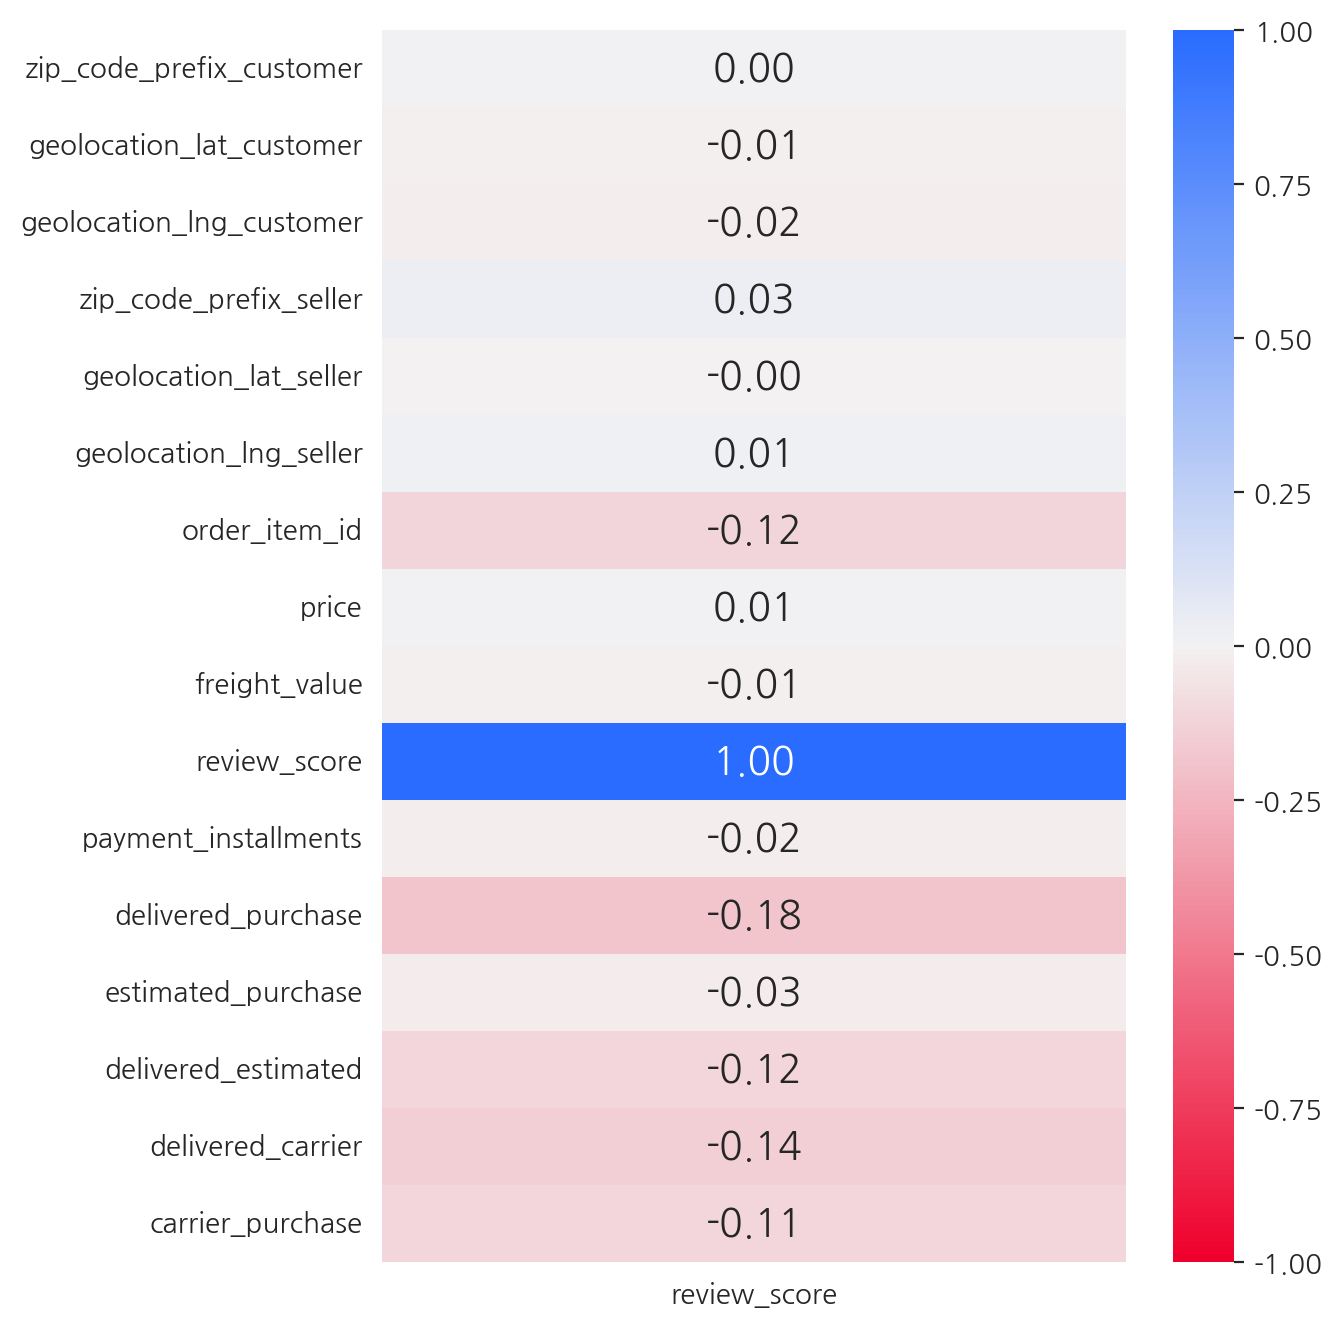

In [59]:
EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
plt.figure(figsize=(6, 8))
plt.title(f"")
sns.heatmap(data=df_temp["review_score"].to_frame(), annot=True, fmt=".2f", annot_kws={"size": 14}, cmap=color_heatmap, vmin=-1, vmax=1)
# sns.heatmap(data=df_temp["review_score"])
plt.show()

### sns.heatmap3 - ["review_score"][deri_list]



┌▣ sns.heatmap(data=df.corr(), annot=True, fmt=".2f") ---- ---- ---- ----


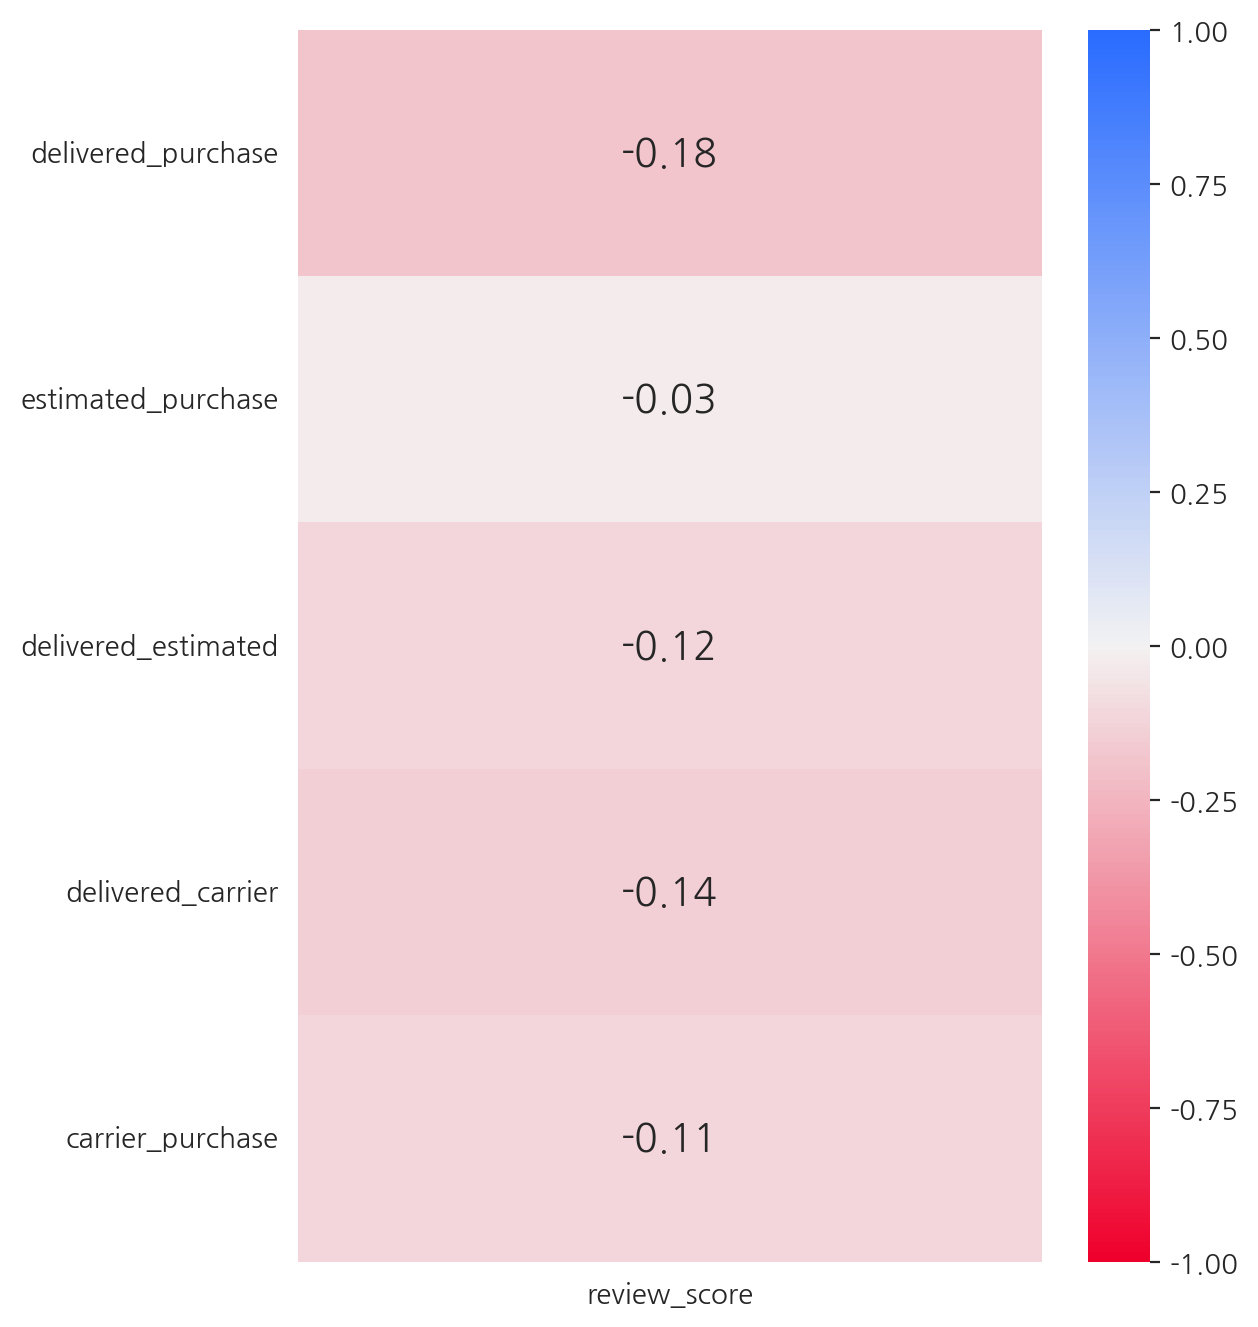

In [60]:
EDA.print_title("""sns.heatmap(data=df.corr(), annot=True, fmt=".2f")""")
plt.figure(figsize=(6, 8))
plt.title(f"")
sns.heatmap(data=df_temp["review_score"][deri_list].to_frame(), annot=True, fmt=".2f", annot_kws={"size": 14}, cmap=color_heatmap, vmin=-1, vmax=1)
# sns.heatmap(data=df_temp["review_score"])
plt.show()

### sns.regplot

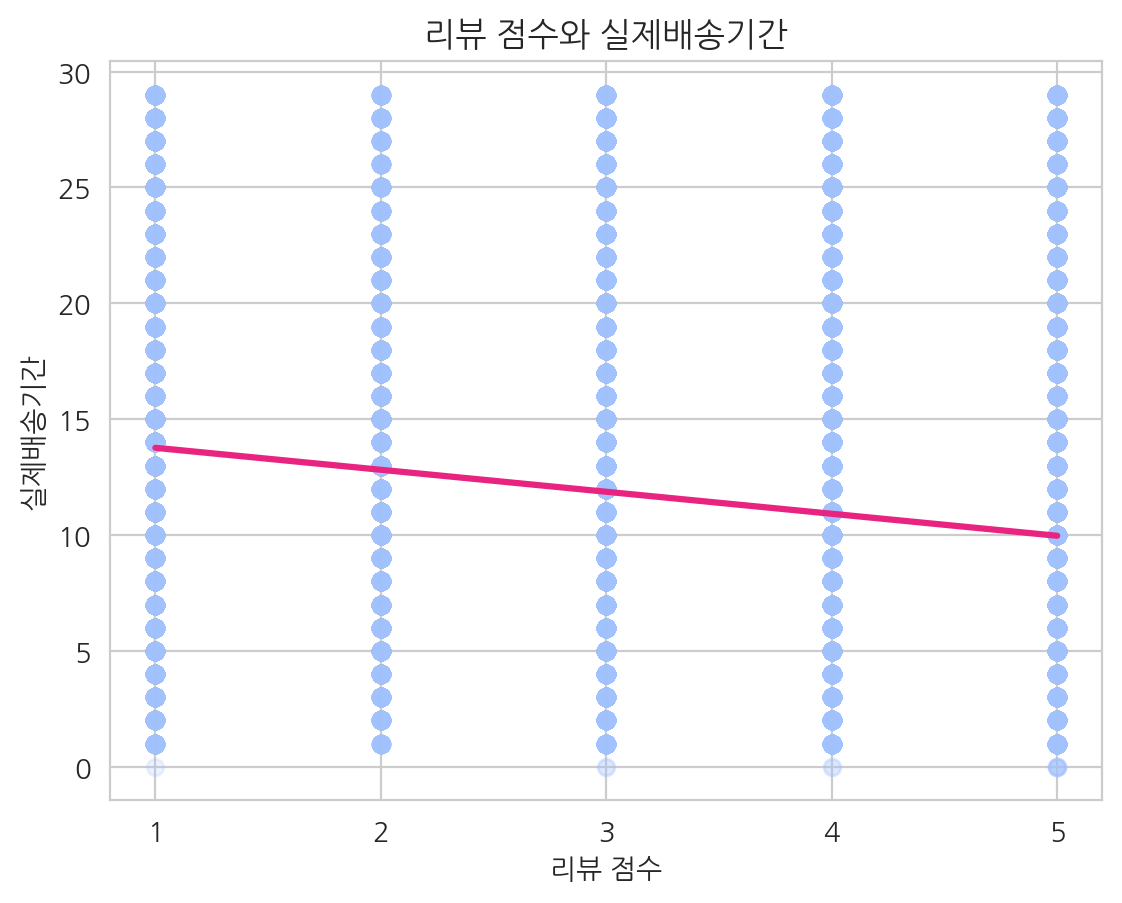

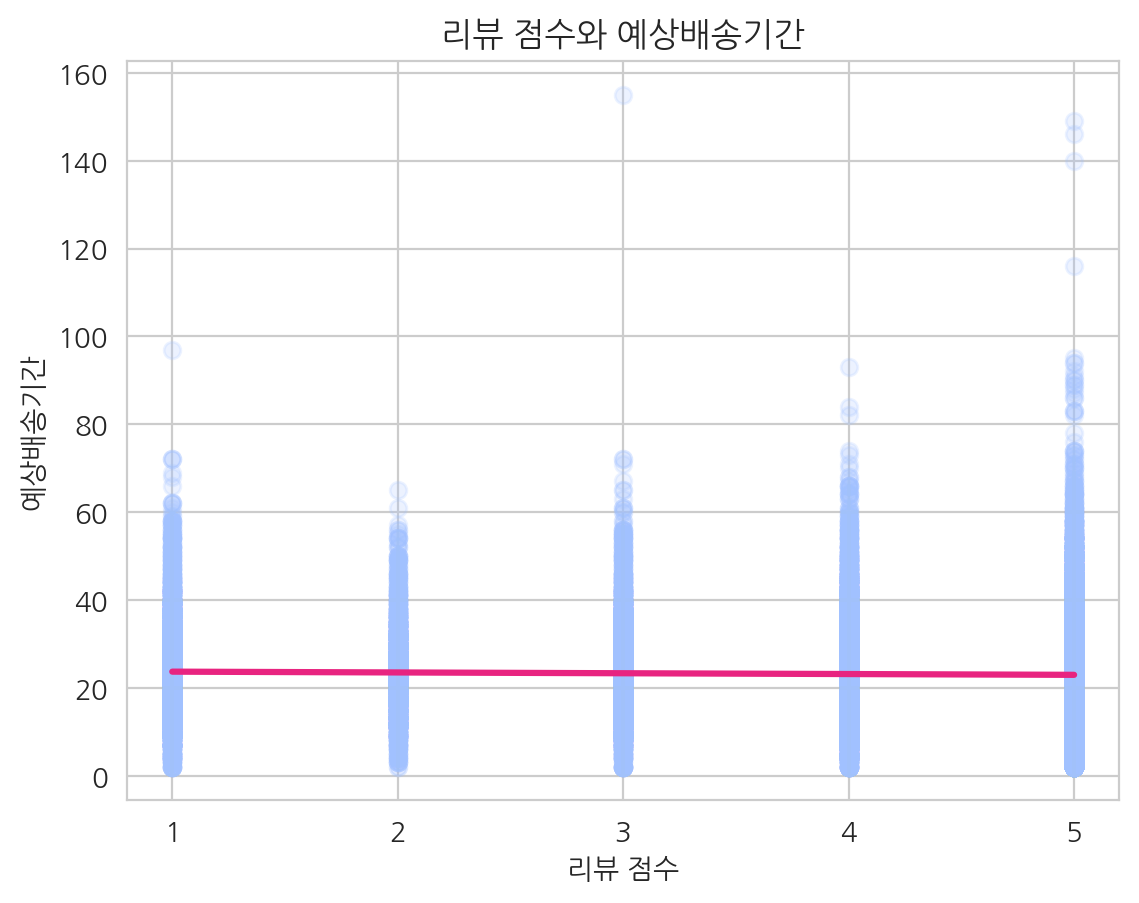

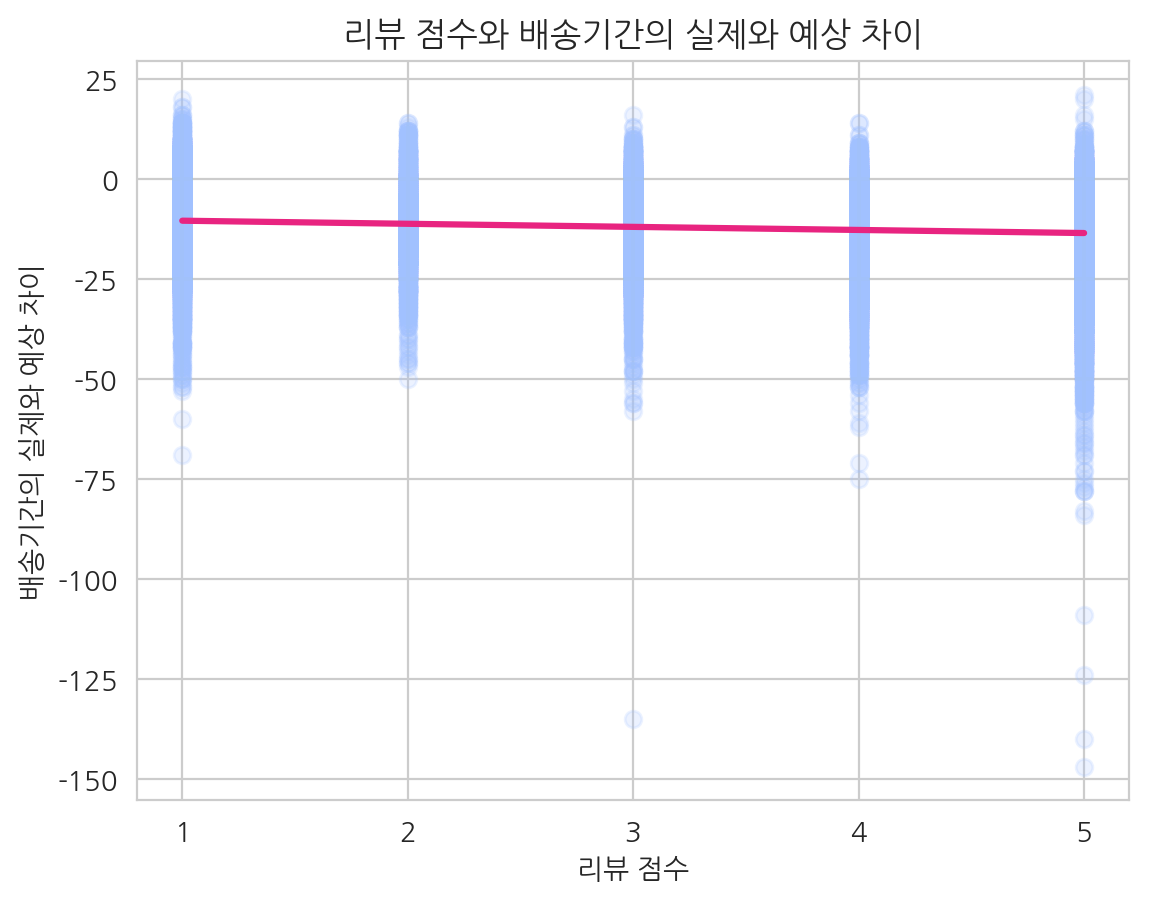

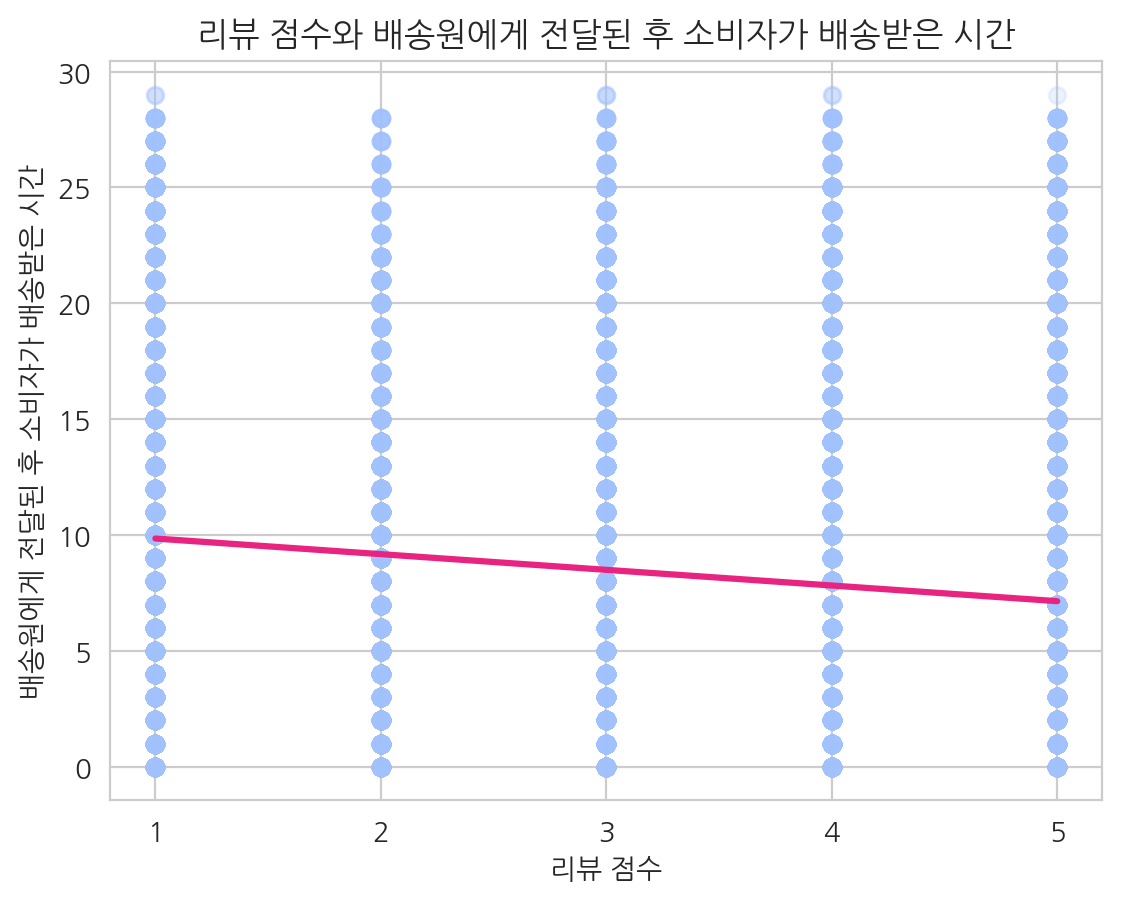

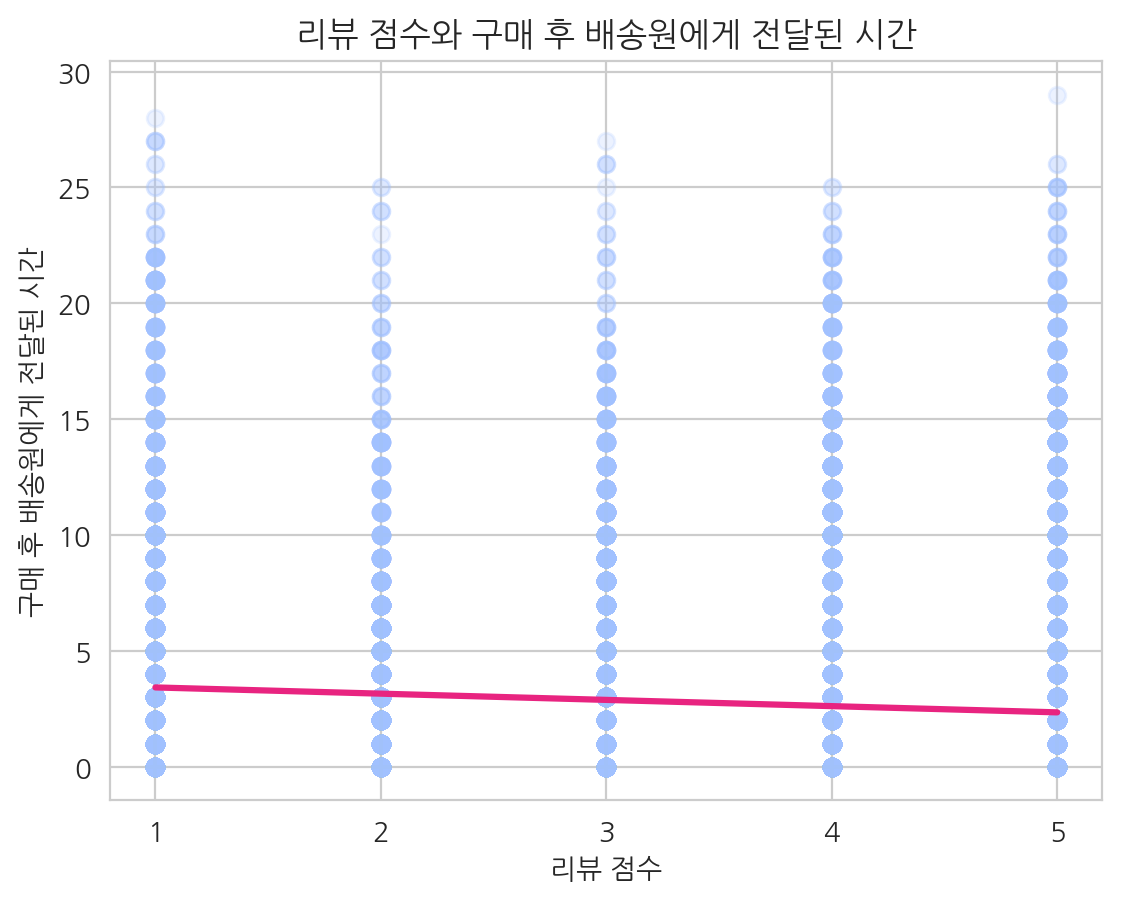

In [61]:
df_temp = df_cor_outlierDrop.copy().reset_index()

df_temp[deri_list + ["review_score"]]

for i in deri_list:
    df_temp[i] = df_temp[i].dt.days
    sns.regplot(data=df_temp, x="review_score", y=i, scatter_kws={"color": "#a1c1ff", "alpha": 0.2}, line_kws= {"color":"#e82480", "alpha": 1})
    plt.title(f"리뷰 점수와 {dict_title[i]}")
    plt.xlabel("리뷰 점수")
    plt.xticks(ticks=[1, 2, 3, 4, 5])
    plt.ylabel(f"{dict_title[i]}")
    plt.show()

### sns.barplot

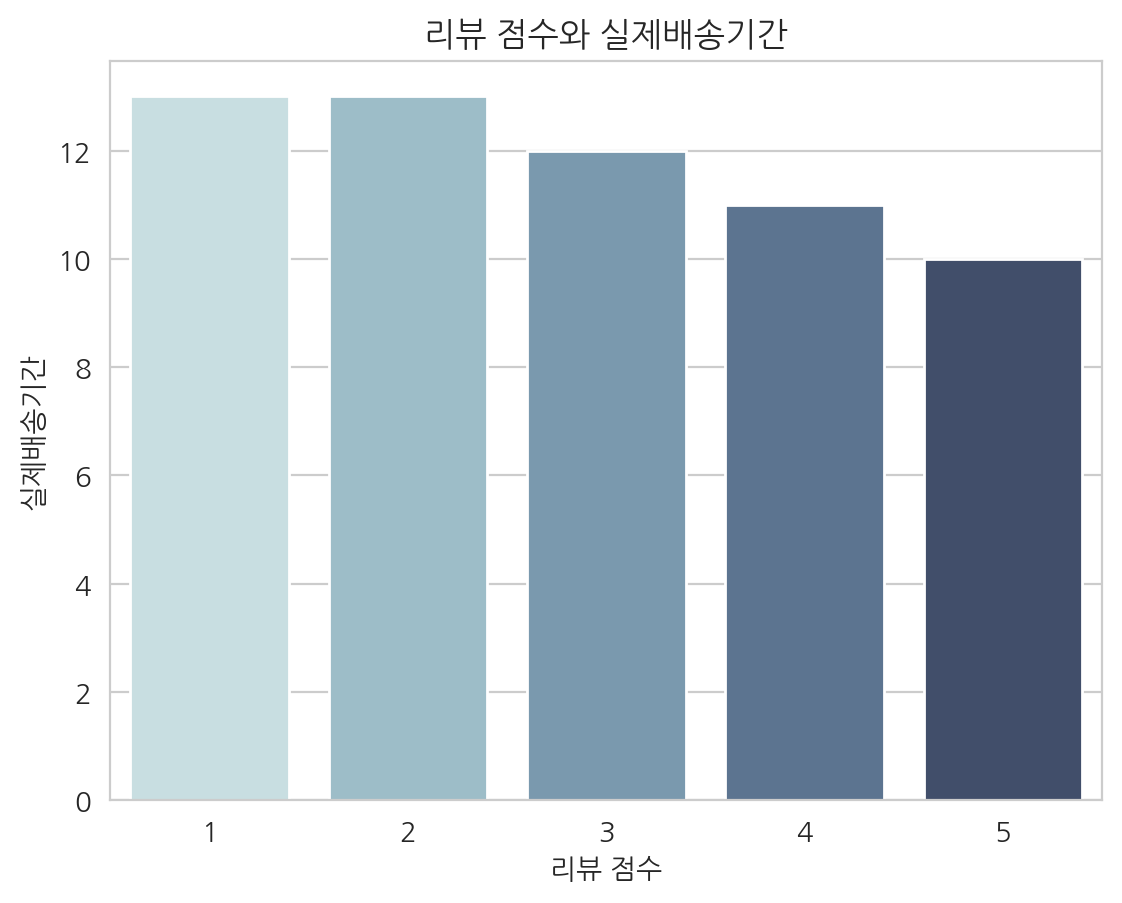

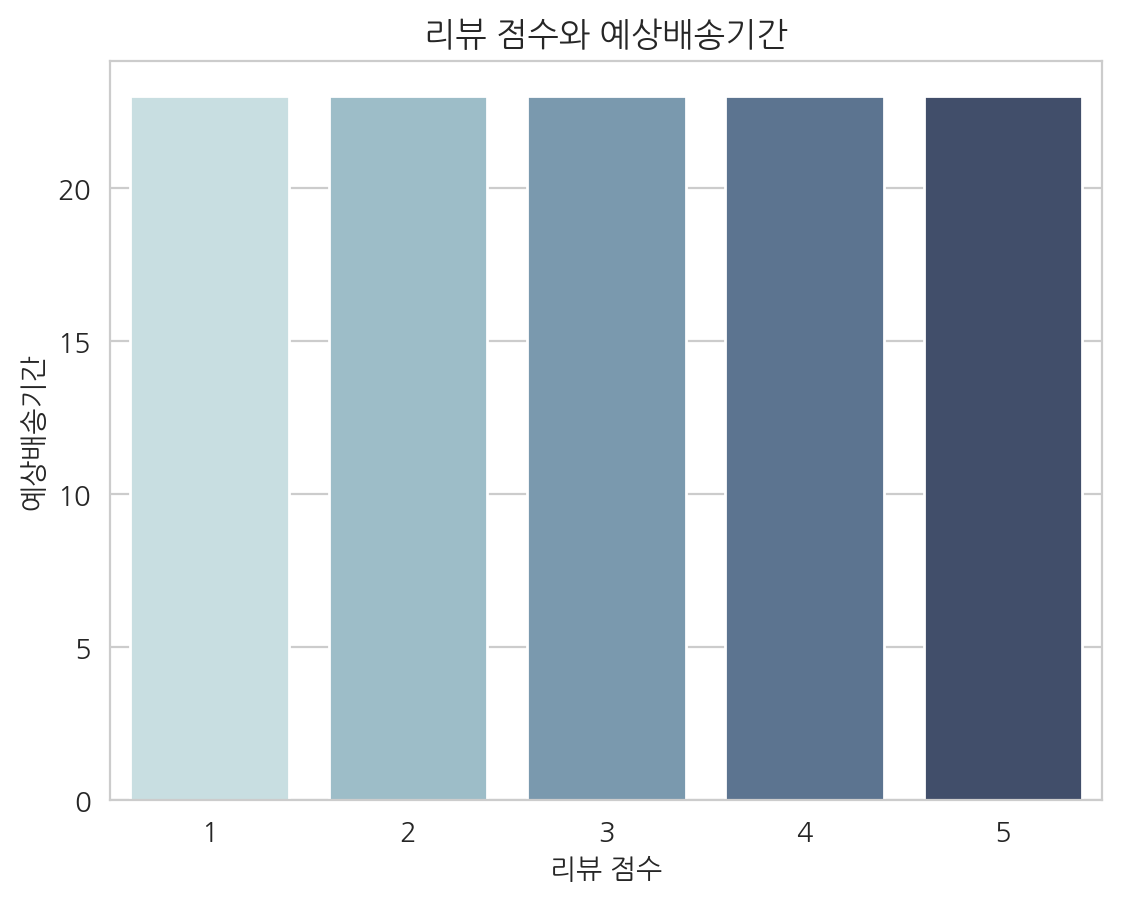

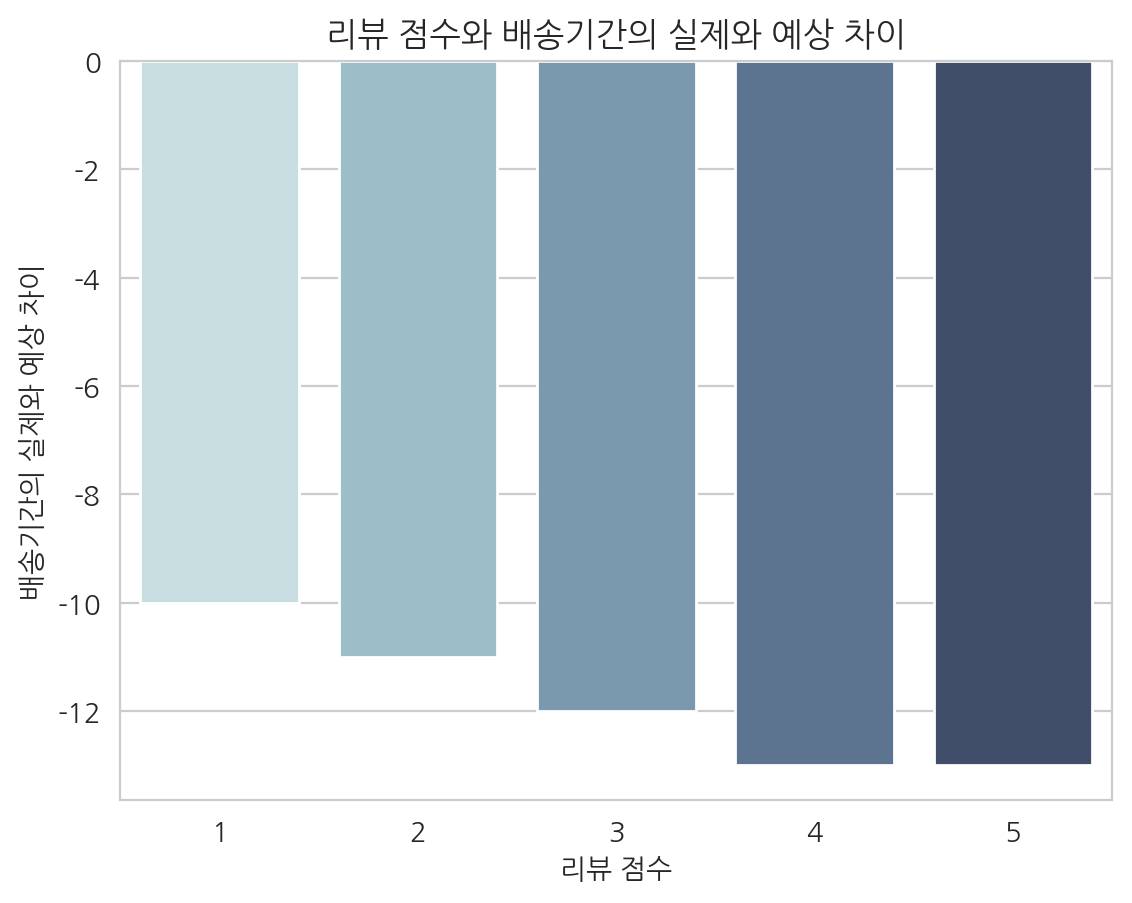

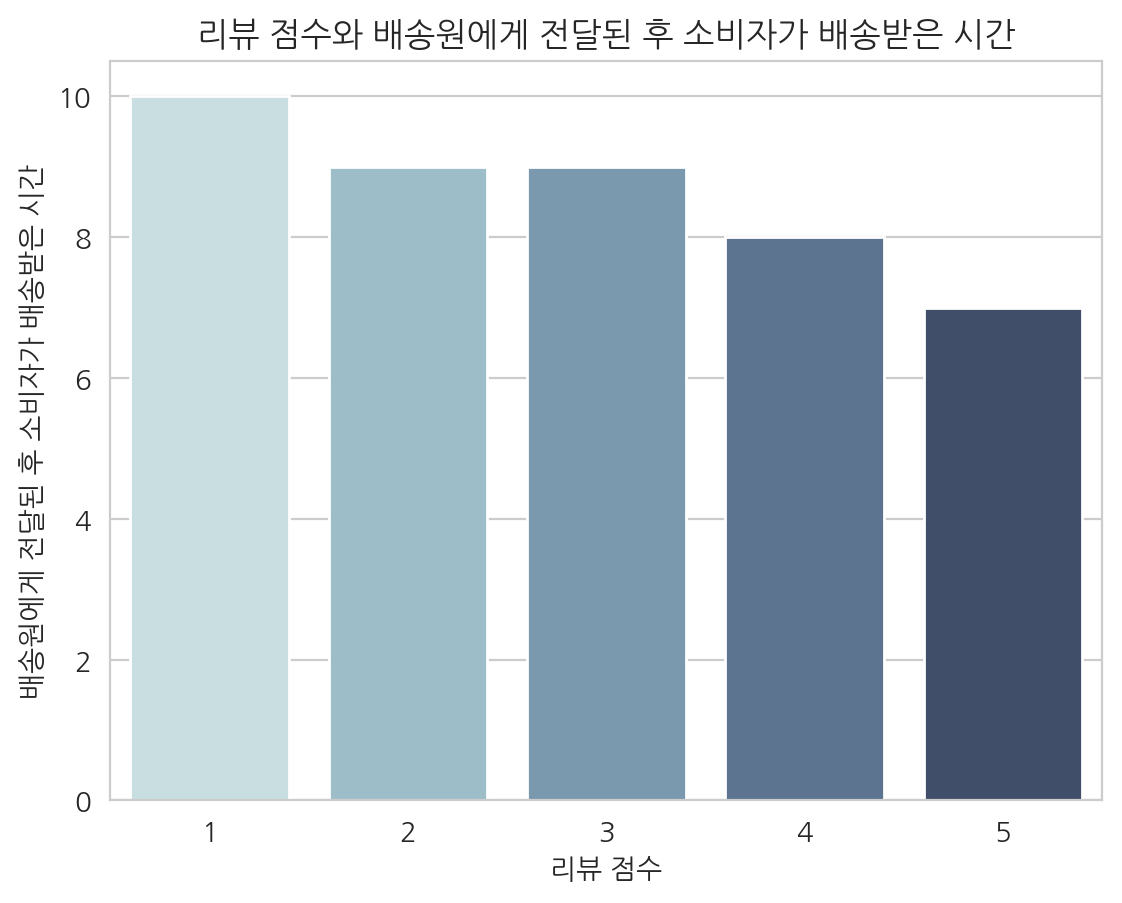

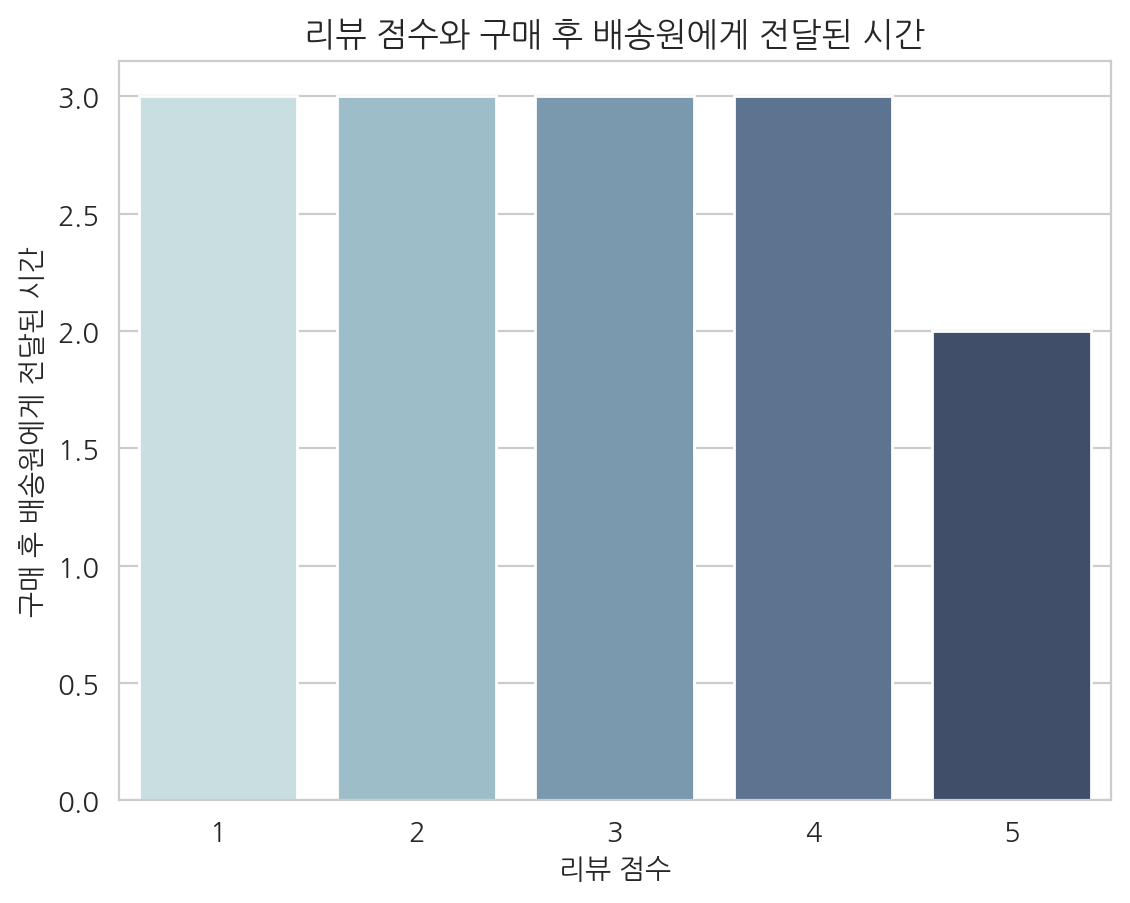

In [62]:
df_temp = df_cor_outlierDrop.copy().reset_index()[deri_list + ["review_score"]].groupby("review_score")[deri_list].mean().reset_index()

for i in deri_list:
    df_temp[i] = df_temp[i].dt.days

for i in deri_list:
    sns.barplot(data=df_temp, x="review_score", y=i, palette=color)
    plt.title(f"리뷰 점수와 {dict_title[i]}")
    plt.xlabel("리뷰 점수")
    plt.ylabel(f"{dict_title[i]}")
    plt.show()

# 리뷰점수와 배송비 관계

## Data Load

In [63]:
df_raw = pd.read_csv(f"{data_olist_path}/complete_orders.csv", index_col=0)

### Check

In [64]:
# EDA.Check_df(df_raw)

### Summary


In [65]:
# EDA.Summary_df(df_raw)

## 분석 : 배송비

In [66]:
df = df_raw.copy()

df.groupby("review_score")["freight_value"].mean()

review_score
1   21.582
2   21.192
3   20.371
4   20.233
5   19.812
Name: freight_value, dtype: float64

### sns.barplot

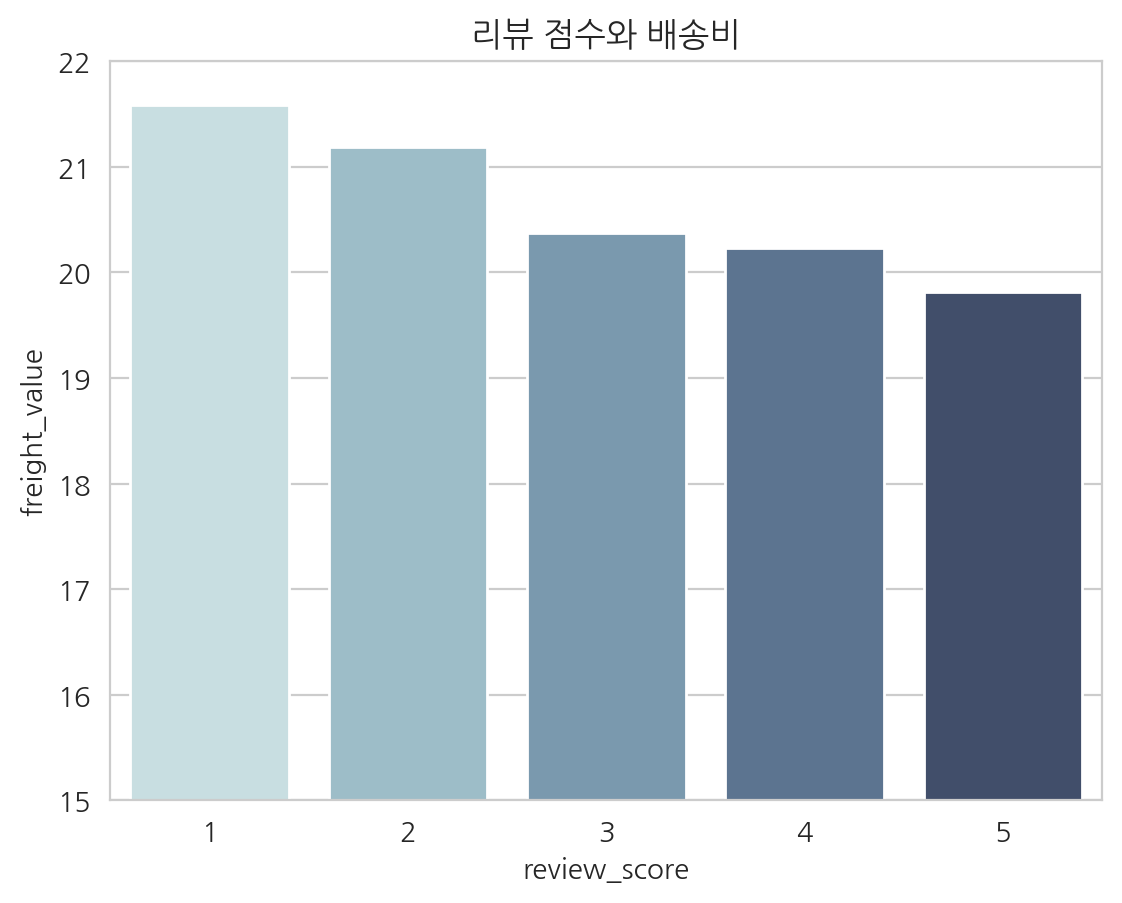

In [67]:
plt.ylim([15, 22])

sns.barplot(data=df, x="review_score", y="freight_value", errorbar=None, palette=color)
plt.title("리뷰 점수와 배송비")
plt.show()

## 분석 : 배송비 / 가격

In [68]:
df = df_raw.copy()

df["freight_ratio"] = df["freight_value"] / df["price"]
df["freight_ratio"]

order_id
e481f51cbdc54678b7cc49136f2d6af7   0.291
128e10d95713541c87cd1a2e48201934   0.259
0e7e841ddf8f8f2de2bad69267ecfbcf   0.259
bfc39df4f36c3693ff3b63fcbea9e90a   0.470
53cdb2fc8bc7dce0b6741e2150273451   0.192
                                    ... 
87b4c933f31145a28413b39d880ad6c3   0.470
e8fd20068b9f7e6ec07068bb7537f781   0.051
cfa78b997e329a5295b4ee6972c02979   0.271
9c5dedf39a927c1b2549525ed64a053c   0.182
66dea50a8b16d9b4dee7af250b4be1a5   0.268
Name: freight_ratio, Length: 92657, dtype: float64

In [69]:
df.groupby("review_score")["freight_ratio"].mean()

review_score
1   0.324
2   0.330
3   0.328
4   0.313
5   0.302
Name: freight_ratio, dtype: float64

### sns.barplot

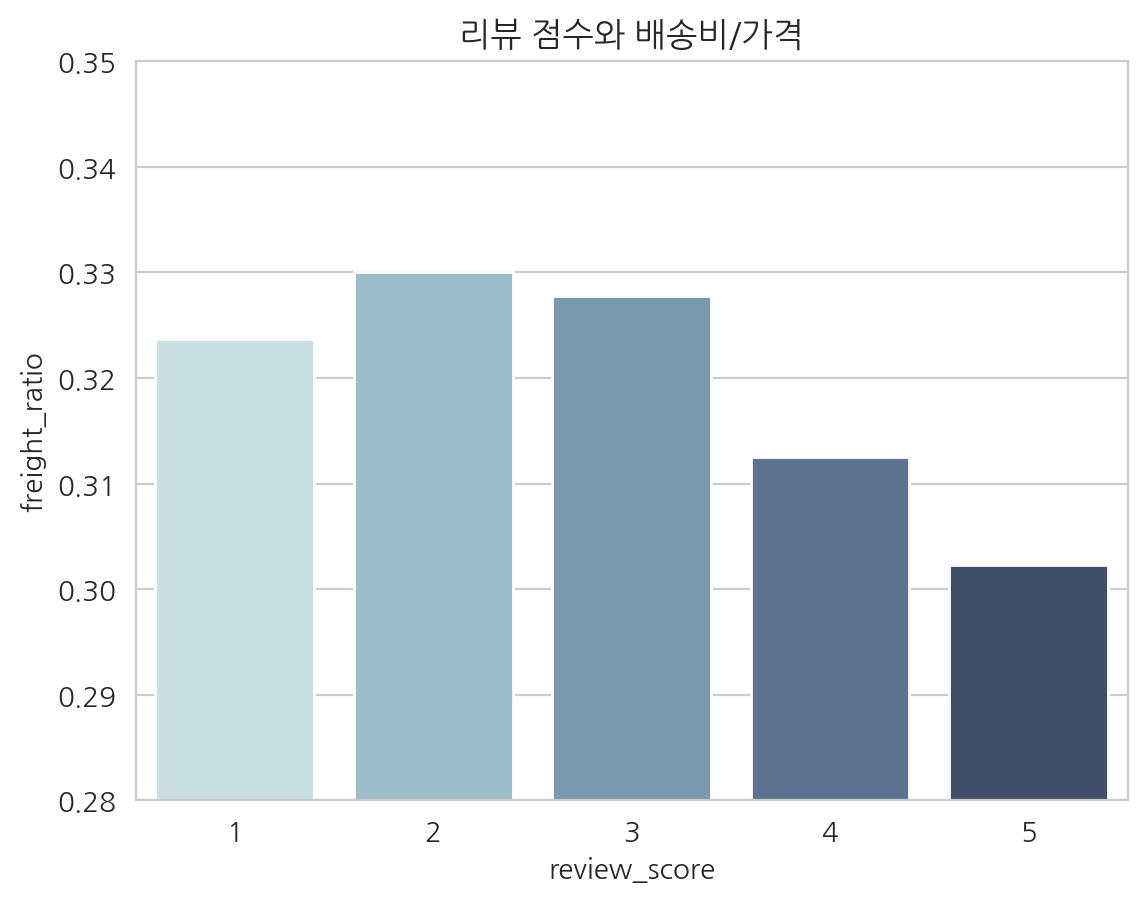

In [70]:
plt.ylim([0.28, 0.35])

sns.barplot(data=df, x="review_score", y="freight_ratio", errorbar=None, palette=color)
plt.title("리뷰 점수와 배송비/가격")
plt.show()